# Fundamentals of Artificial Intelligence Programme (2024/25 Q1)
## Multiobjective optimization for decision support
Dr. Jazmin Zatarain Salazar

In this assignment, we use two python libraries, one for exploratory modeling analysis [The EMA workbench](https://emaworkbench.readthedocs.io/en/latest/) and one for multiobjective optimization [Project Platypus](https://platypus.readthedocs.io/en/latest/), you can install both with pip as follows:

In [1]:
!pip install ema_workbench platypus-opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00


# The Lake model

The goal of this assignment is to demonstrate the use of multiobjective evolutionary optimization, to learn how to visualize and interpret the optimization results, and to use performance metrics to assess the results obtained via multiobjective evolutionary optimization.  We will use the lake problem as a test case, this is a classic problem initially developed by Carpenter et al. (1999) where the population of a city has to decide the amount of annual pollution it will release into a lake.  In this exercise, we will use the adapted version in [Quinn et al. 2017](https://www-sciencedirect-com.tudelft.idm.oclc.org/science/article/pii/S1364815216302250?casa_token=wBdtfic9L4YAAAAA:Oum4EU3ob7bgKoCK2WhEFfOfIGUrsXpvp7PSvnRyMbDSF8lHXdf48H5hMe6d0DS1zChv5IhO) were the problem is defined as a state-based control problem (where actions are a function of the state of the system).  In this case, the 'action' is the Phosphorous (P) emissions which are optimized to balance the economic benefits and the quality of the lake. Since this is a multi-objective problem,  we need a flexible function to map the states to actions, so we use radial basis functions to parameterize the emission control policies. In fact, the MOEA will search for the optimal radii, centers and weights that yield good performance for the objectives of the lake model described below.  See the paper for more details about the problem formulation.

The model is defined by the following equation:

$
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
$

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable where $a_t \in [0,0.1]$.

There are four outcomes of interest. The first is the average concentration of phosphor in the lake.

$
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t
$

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time.
The second objective is the economic benefit derived from polluting the lake defined as the discounted benefit of pollution minus the costs of having a polluted lake.

$ f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t$

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate.

$ f_{inertia} = \frac{1}{\left\vert{T}\right\vert-1}\sum \limits_{t=1}^{\left\vert{T}\right\vert}I(|a_{t}-a_{t-1} |>\tau)$

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

$
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} )
$

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values.

# Lake model implementation in python

In [2]:
import math
import numpy as np
from scipy.optimize import brentq


def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    '''

    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1

    Returns
    -------
    float

    note:: w2 = 1 - w1

    '''

    rule = w1 * (abs(xt - c1) / r1) ** 3 + (1 - w1) * (abs(xt - c2) / r2) ** 3
    at1 = max(rule, 0.01)
    at = min(at1, 0.1)

    return at


def lake_model(b=0.42, q=2.0, mean=0.02,
               stdev=0.001, delta=0.98, alpha=0.4,
               nsamples=100, myears=100, c1=0.25,
               c2=0.25, r1=0.5, r2=0.5,
               w1=0.5, seed=123):
    '''runs the lake model for nsamples stochastic realisation using
    specified random seed.

    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    delta : float
            future utility discount rate
    alpha : float
            utility from pollution
    nsamples : int, optional
    myears : int, optional
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    seed : int, optional
           seed for the random number generator

    Returns
    -------
    tuple

    '''
    print(c1,c2,r1,r2,w1)

    np.random.seed(seed)
    Pcrit = brentq(lambda x: x ** q / (1 + x ** q) - b * x, 0.01, 1.5)

    X = np.zeros((myears,))
    average_daily_P = np.zeros((myears,))
    reliability = 0.0
    inertia = 0
    utility = 0

    for _ in range(nsamples):
        X[0] = 0.0
        decision = 0.1

        decisions = np.zeros(myears, )
        decisions[0] = decision

        natural_inflows = np.random.lognormal(
            math.log(mean ** 2 / math.sqrt(stdev ** 2 + mean ** 2)),
            math.sqrt(math.log(1.0 + stdev ** 2 / mean ** 2)),
            size=myears)

        for t in range(1, myears):
            # here we use the decision rule
            decision = get_antropogenic_release(X[t - 1], c1, c2, r1, r2, w1)
            decisions[t] = decision

            X[t] = (1 - b) * X[t - 1] + X[t - 1] ** q / (1 + X[t - 1] ** q) + decision + \
                   natural_inflows[t - 1]
            average_daily_P[t] += X[t] / nsamples

        reliability += np.sum(X < Pcrit) / (nsamples * myears)
        inertia += np.sum(np.absolute(np.diff(decisions)
                                      < 0.02)) / (nsamples * myears)
        utility += np.sum(alpha * decisions * np.power(delta,
                                                       np.arange(myears))) / nsamples
    max_P = np.max(average_daily_P)
    return max_P, utility, inertia, reliability

## 1. Connecting the lake model with the EMA workbench.

Given the Python implementation of the lake problem above, adapt the code and connect it to the EMA workbench
using the following lever ranges and uncertainty ranges:

|Levers 	|Range	        |Default value|
|-----------|--------------:|------------:|
|$r1$    	|0.0 – 2.0	    |0.5          |
|$r2$	    |0.0 – 2.0 	    |0.5.         |
|$c1$      	|-2 – 2	        |0.25         |
|$c2$	    |-2 – 2	        |0.25         |
|$w1$	    |0.0-1.0    	|0.5          |


|Uncertainties	|Range	        |Default value|
|---------------|--------------:|------------:|
|$\mu$    	    |0.01 – 0.05	|0.02         |
|$\sigma$	    |0.001 – 0.005 	|0.0017       |
|$b$      	    |0.1 – 0.45	    |0.42         |
|$q$	        |2 – 4.5	    |2            |
|$\delta$	    |0.93 – 0.99	|0.98         |
    
You can follow [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/directed-search.html)for guidance.

The outcomes in the EMA workbench refers to the objectives of the problem, in this case we have four. 1) maximum Phosphorous (to be minimized) 2) utility (to be maximized) 3) intertia (to be maximized), and reliability (to be maximized).  Use an alpha value of 0.41, with number of samples= 150, and number of years = 100.

In [3]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model

model = Model("lakeproblem", function=lake_model)

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P", ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
model.constants = [
    Constant("alpha", 0.41),
    Constant("nsamples", 150),
    Constant("myears", 100),
]

## 2. How would you introduce a constrain within the optimization to reflect a desired performance threshold for a given objective?

You don't actually have to perform this step, simply specify how you would go about establishing a constraint in the optimization formulation, in such a way that it only finds solutions with maximum pollution (max phosphorous) of 0.85.

In [4]:
from ema_workbench import Constraint
constraints = [Constraint("max pollution", outcome_names="max_P", function=lambda x: max(0, x - 0.85))] # why this limits the max pollution to 1??


# 3.  Run the optimization and track the performance metrics

Tip: the EMA Workbench uses [Platypus](https://github.com/Project-Platypus/Platypus) to run the optimization via the evaluator class, you can also collect metrics during runtime specifying the convergence option. Below is a sample snippet on how to run the optimization and collect performance metrics during runtime.

In [5]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[1,1.01,1.01,1.01]),
                       EpsilonProgress()]

ema_logging.log_to_stderr(ema_logging.INFO)



with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=10000,
        searchover='levers',
        epsilons=[0.1, 0.1, 0.01, 0.1],
        convergence=convergence_metrics,
        constraints=constraints)



[MainProcess/INFO] pool started with 2 workers
  0%|                                                | 0/10000 [00:00<?, ?it/s]

0.10648322205206773 -0.70880643185541990.3547394662441308 -0.38081108905962324 0.007201677586296418  1.71513623874143020.44468972268853735  0.86997035536033930.17194986671030732
 0.5134311880823016
1.2710531364717008 1.0716325542779468 -0.2160885101283534 1.2622882694809558-1.924142843875917 1.2158891691583114 0.4549730920197248  0.93055287880879091.9158593755301976 
0.34025965841937345
-1.3402696339355975 0.5886722874486239 0.22783207552130502 1.82275787174900961.5252548894293279  0.5854803044690985
-0.5739242923900991 1.5582026177719677 1.0113518011338904 0.1027949876463079
-1.8361154318167277 -0.035989177923431814 1.222609390763805 0.5739213157509784 0.67946884848318891.6390209053756064 
-0.9288856042504121 0.8464253272184157 0.45221641996131035 0.6998195562708898
1.938549767305838 1.2254204515644997 1.2669978424457347 0.1421769258631802-1.6468280299580589 0.5965733193286105
 -1.4636120520060358 0.09223670612502666 0.3894794889146558 0.4906717420207577
0.7916095516485431 0.196265620

  1%|▍                                     | 100/10000 [00:24<39:41,  4.16it/s]

-0.106012621838662110.8844810767414906  0.10064060187224433 0.5645532401329978 0.10741014807400187
0.31656789736713886 1.7527401239469618 1.485865119675061 1.411085241092021 0.22226017778428594
1.4825275352234497 -1.520167742705505 1.1878062623110133 1.157747673160068 0.895931109521543
-0.251507888714085 -0.989807688683213 0.36886000305666866 1.400210450093683 0.9316496492483455
-1.113875556703824 -1.3568829176379995 0.7319593996980098 0.0741839110919642 0.755083339569284
0.529156854764718 -0.08044707660465344 1.4809091342474212 0.5968847683627851 0.881474793011224
1.6390209053756064 -0.821877723325505 0.7180115688510333 1.4245773597064502 0.6998195562708898
0.9779633696241739 0.2321082557942442 1.4041091143435005 0.40095116911041917 0.3913305155785045
-0.1427243408216694 -0.9182152823537453 1.6598200656244797 0.2769349164072762 0.6240054920127053
1.0716325542779468 -1.924142843875917 0.4748160112597086 1.832860083450893 0.34025965841937345
0.6629985482728604 -1.8324511170342161 1.1424

  2%|▊                                     | 200/10000 [00:40<31:11,  5.24it/s]

0.134131955512962530.05982792528180614  -0.75304771751173360.2688622377199472 1.1043469103040464  1.09704178208321081.9304679747072249  1.41059450039982150.6209350970359927 
0.3042371405774896
-0.10601262183866211 0.8844810767414906 0.10064060187224433 0.5645532401329978 0.5434726140617956 0.87753599694535410.06654592296586959
 1.471372990834712 0.24479189800421453 0.07759163112790457
1.0433414708917397 1.4071865388367115 1.7019056921967972 1.915084985758533 0.15240332476516805
0.13413195551296253 -0.6810250437226855 1.1043469103040464 1.9304679747072249 0.5168702884042939
0.3975552924982648 1.4071865388367115 1.7019056921967972 1.9150849857585331.8381674472407683  0.18493171984752987
1.5662498553206858 0.8866469921423723 1.489341006402111 0.8797668887353631
0.5434726140617956 0.06654592296586959 1.2675851636175484 1.827468876156852 0.8730287057939037
0.26878656053244887 0.8748257607811549 0.10652342391273928 1.8437169489473226 0.855586012739824
0.04034229405764203 1.59491897325586060.

  3%|█▏                                    | 300/10000 [00:54<27:40,  5.84it/s]

0.72927872912775670.2484383673582231 0.19512333740578675  1.8848831588732584 1.8241218398477888 0.6643830246555820.18022478696345967
  0.2998375280669485 1.519033332993720.5303708745971536
0.7087223138070842 0.06085874792682962 0.35514803814167021.8188587954792077  0.279684704150569450.9901616785912549  0.58637420405091251.4249613153138356 
0.866947202405188 0.2504991926603406
0.4717320196499952 0.638632311860916 1.4930268502062265 1.1892478339157855 0.210784428691493160.26878656053244887
 0.9968587037645995 0.10652342391273928 1.8437169489473226 0.9324965395629302
0.16442353468859494 0.638632311860916 1.485865119675061 1.356191186884955 0.23825333362697731
0.25912134321596947 0.11079887353774343 0.4963532815346239 1.5368273749029344 0.5257312645157736
0.9009734278389874 1.6207054102980918 1.9312070407408628 1.5650791002277646 0.88233113248771260.5434726140617956 
-0.01930011376764762  1.61545317728621861.827468876156852 0.24660181762685685
0.06252007921823532 0.6407230202586279 1.1042

  4%|█▌                                    | 400/10000 [01:08<24:55,  6.42it/s]

0.35514803814167020.5389945778550629  0.73455266478150350.35237494628541244  1.3987846619856831.4451469948984144  1.19618354745232641.3412499418579633  0.87704479820464180.4749362982651442

0.2484383673582231 0.059827925281806140.18022478696345967 0.07355592963700497  0.52721739778455130.9638192087468227  1.5157115951303601 1.41391623826318160.5303708745971536 
0.3042371405774896
0.5434726140617956 0.08107726303526580.22974272241357518  1.43197682537268030.06680677283035863  0.403853196754757171.7113017627745877  0.7650487515235967 1.38741469857760170.2592642688154676

0.33623303129757076 0.28707946553515185 1.1134673073800194 1.2741884631323916 0.2592642688154676
-0.10739610907843389 0.03379024890776197 1.647686733437429 1.357426476173363 0.8501458433238844
0.5389945778550629 0.3459980342100056 1.432787990326479 1.2481278974898111 0.8557031871976045
-0.1911949646832607 0.24661706586179516 1.4113536233121498 1.365885894848683 0.8501458433238844
0.38511395030134543 0.2661395252607648 1.

  5%|█▉                                    | 500/10000 [01:21<23:39,  6.69it/s]

-0.120157572021460630.4049974254905997  0.44773484802302455-0.04427297192511917  1.21265181532799550.5272173977845513  1.3539759044741708 0.5737164396588890.6794688484831889 
0.5700332840546223
0.2915667760644065 0.2701791046887009 1.0970417820832108 1.535429572087376 0.30022398986879470.25912134321596947
 0.3193186927320816 0.4892966178056959 1.4119923032153798 0.524575183972835
0.3412846152730924-0.030421046040265243  0.429480995830889170.08153235437427014  1.22225494286509261.7492328102347252  1.35419990665879620.565981544109786  0.69128814740623030.2592642688154676

0.4717320196499952 0.638632311860916 1.4930268502062265 1.3414272231725026 0.210784428691493160.3551480381416702
 0.35237494628541244 1.4450539923125187 1.1895500171593407 0.36393714317188414
0.3551480381416702 0.35237494628541244 1.4291471664543485 1.5342148854534718 0.525017516756848
0.25912134321596947 0.42148597363889095 0.4963532815346239 1.3443418958655184 0.384470344333054
0.3228775930556549 0.3752188560788867 0.

  6%|██▎                                   | 600/10000 [01:35<22:39,  6.91it/s]

0.078892595310601110.06025043071417091 0.2688622377199472  0.2686741164872418 1.6224106715846232 0.9665115181244577 0.54235112827859510.3372181585221544  0.92788068476569640.5661247367184389

0.33623303129757076 0.28707946553515185 1.1134673073800194 1.8232316482446036 0.2592642688154676
0.24571107227700786 0.6005540217459422 1.0970417820832108 1.2714317399231936 0.867791681450156
-0.13931634879443622 0.3229977072134864 1.9828653209030498 1.700221172575959 0.859714839912342
-0.18991718409991343 0.07412638398169075 1.2985185219529 1.2090095125381919 0.20667834920999673
0.5434726140617956 0.0425189225315874 1.474508524473524 0.24479189800421453 0.0194658631563428
0.07889259531060111 -0.057337427038891164 1.7211720791900018 0.43857673057887925 0.9831753281244457
0.3828006752259249 0.35237494628541244 1.4291471664543485 1.4581687742494527 0.5288273082489147
0.3974828568517747 0.18022478696345967 0.60080208131251121.3432618097966946  0.38912582158134623
0.2915667760644065 0.2028120117198669

  7%|██▋                                   | 700/10000 [01:50<22:35,  6.86it/s]

0.38257887231864050.4367959450525043  0.429480995830889170.44773484802302455  0.50466543699644341.2352037933143225  1.36171079408255680.565981544109786 0.5700332840546223 
0.6794688484831889
0.3367105218396137 0.3927200587875357 1.200288110624077 0.48282230395384573 0.6794688484831889
0.47285661495123676 0.3152031790444222 1.5029848700877786 0.2890741127042009 0.06913794266723816
0.6104969869069444 0.4497739576324027 1.7129170946119245 0.3372181585221544 0.5661247367184389
0.0411548528382481 0.16085750094363327 1.1734187340355033 1.291292204049549 0.26410892273937553
0.5834585678818964 0.16085750094363327 1.7748977596503366 1.8101885354559957 0.8917500041322102
0.23034333498034334 0.6005540217459422 1.042606279288222 1.2471616537986185 0.2652148233344213
0.2484383673582231 0.5179430173491153 0.5272173977845513 1.5157115951303601 0.541809792673028
0.3823412477304387 0.2747637318167335 1.4201181104316374 1.1549620134506837 0.2456108126237605
0.2915667760644065 0.9220632457500069 1.097041

  8%|███                                   | 800/10000 [02:02<21:28,  7.14it/s]

0.23458952528656912 0.11079887353774343 0.55765132518214670.6320378827479849  0.072569322542724911.5330039190141727  1.8555627183701190.5257312645157736 
0.2890741127042009 0.37661042792915744
0.26053727776997887 0.06503152221431086 0.6269003942705522 1.308373258058255 0.524575183972835
0.3811629377646311 0.07450650005330717 0.5272173977845513 1.270967108009972 0.5341965332561321
0.4984003326648897 -0.02164087849884816 1.7214825248883727 0.2890741127042009 0.37661042792915744
0.2915667760644065 0.5965258826258389 1.2602360761624294 1.4105945003998215 0.31832939346045036
0.5427808675846659 0.3152031790444222 1.4300378500713733 0.2890741127042009 0.8466550773051843
0.33917054656081036 0.18271067827927145 1.6787768726648775 0.5968847683627851 0.10472093734673826
0.0411548528382481 0.47668801581141146 1.1734187340355033 1.291292204049549 0.26410892273937553
0.26824127571863343 0.40370279977463547 0.5777523765006118 1.527331049413291 0.5277663024487299
0.5427808675846659 0.3146504728525504 

  9%|███▍                                  | 900/10000 [02:15<20:45,  7.31it/s]

0.148848175794304650.3825788723186405 0.27789929681613756  0.453414567105298041.4249613153138356  0.50466543699644340.8608367344350839  1.36171079408255680.25057982282752256 
0.5700332840546223
0.25912134321596947 0.3193186927320816 1.105562402727828 1.8447925779405598 0.8781990512702401
0.21395854826005892 -0.4939989775511925 0.5177936016230213 1.820478516549321 0.6353191321712343
0.2484383673582231 0.3636898777314898 0.5777523765006118 1.51903333299372 0.9226075347722963
0.15899287467097845 -0.01995242396105895 1.7243076128640675 0.3180477429614179 0.552933881089907
0.25915350056905806 0.07717546275591355 0.6614084549070336 1.4841148802080801 0.5257312645157736
0.26810496864095723 -0.30253203721489264 0.6269003942705522 1.308373258058255 0.5130451890072101
0.3825788723186405 0.44773484802302455 0.5046654369964434 1.5277802729503704 0.5700332840546223
0.2484383673582231 0.18022478696345967 0.5777523765006118 1.3612615705454774 0.5277663024487299
0.06025043071417091 0.27073632664270386

 10%|███▋                                 | 1000/10000 [02:29<20:28,  7.32it/s]

0.5412186387889610.3157466308023738  0.072098803880488190.17602725639209676  1.72148252488837270.6690703483060586  0.252891611400270171.2632435099493668 0.3484503211811483 0.3633196540720357

0.06025043071417091 0.2688622377199472 1.7333921301918547 0.44900682409492015 0.5332472336994591
0.07310150768997284 0.2686741164872418 0.5780170535711437 0.4682584216882102 0.9248135613196535
0.4053092469135525 0.07602666045490748 0.4963532815346239 1.3279396559849381 0.5001953222529364
0.29881033248303956 0.18022478696345967 0.5636943247553106 1.3077281529460656 0.46807694580046216
0.259010493171367 0.5447375046225731 0.4963532815346239 1.551146298760461 0.5705916572549745
0.33917054656081036 0.18271067827927145 1.6787768726648775 0.5968847683627851 0.08068817167313214
0.09207317753658173 0.26921336577789295 1.7243076128640675 0.3666295709287204 0.9643377657507023
0.4555421006729268 0.2747637318167335 1.4201181104316374 1.151284976918287 0.5122720362115784
0.25912134321596947 0.32063555970083524

 11%|████                                 | 1100/10000 [02:43<20:14,  7.33it/s]

0.173792200218765850.42260857660037  0.045378585943253516 0.41773096798200330.4796316934443685  1.3279396559849381 0.47600181764367966
0.29236872751984844 1.51903333299372 0.9226075347722963
0.15780146813431228 0.37305330140993115 0.4639056730181181 1.527331049413291 0.49287636623934594
0.07889259531060111 0.2695377299433224 1.7573107902805163 0.540299088269732 0.87586772935546
0.249081862363946220.2722398414611125  0.303794771393725460.16590750071271665  0.52721739778455130.258326066517945  1.65402558393749270.557873859243006  0.51345404717159980.5648839736504709

0.25912134321596947 0.401586640860576270.19305753598506478   0.44757079874393821.5368273749029344 0.7202041833591502
0.42948099583088917 1.0925178990029627 0.632882030080544 0.5376001453008269
0.4905756982755687 0.3152031790444222 1.63967747299791070.26811860179900515  0.193057535985064781.5918642192386319  0.069137942667238160.49208257379771014
 0.23433952738077868 0.539022038372917
0.971541992627386 0.24638228929684014 1.7

 12%|████▍                                | 1200/10000 [02:57<20:09,  7.28it/s]

0.26053727776997887 0.22800367510430375 0.065031522214310860.18022478696345967 0.6264717286911892  0.56536533789418281.6994719605232482  0.31715871081490670.524575183972835 
0.5277663024487299
0.2567726553892021 0.18022478696345967 0.5272173977845513 0.5663044755688472 0.5134540471715998
0.2485203051002364 0.07176754515306583 0.5254603052740595 1.701437216547641 0.5277523171816431
0.307944837035287 0.09611403594567192 0.5325674741776812 1.4843216159430064 0.5206533094205822
0.25912134321596947 0.04313420221564931 0.55571455144969330.4778787453687623 0.41002529099942425  1.3291355972275430.5966428346950159 0.6083508830710582 
0.5159062239836095 0.5874798515294121
0.26487269777687894 -0.27050971556913117 0.91390710746710780.4118653060278574  1.4441689147825720.41002529099942425  0.55362077462761720.6275060664934531
 0.4471838673969065 0.5874798515294121
0.26745148458572565 0.18022478696345967 0.5812833672274501 1.2807095103804746 0.4886941074575806
0.11251792276166442 0.28367057977173615

 13%|████▊                                | 1300/10000 [03:11<20:10,  7.19it/s]

0.259121343215969470.38106626575268165  0.142679566202820850.19305753598506478  1.21565447750184670.5285868250256373 0.4544337812561434
 0.5473644520768549 1.5368273749029344 0.7202041833591502
0.19376227477945782 0.24152345526990796-0.01014746454276727  0.4450516839612798 1.46702459279796880.16226405773146857  1.3731056543867255 0.5414145958751285
0.5901783338908118 0.38084404842196196
0.29572739081595767 0.0717165231595612 0.41684336057767934 1.3279396559849381 0.3625437359304109
0.833093862514869 0.12539228936853627 1.3669249695414245 0.1916737055233685 0.6650651631723464
0.5415319088998493 0.11127320955979746 1.855562718370119 0.2601425847810523 0.268712028390101
0.5763937790238702 0.07250593080692487 1.4319024752760527 0.3749578247298801 0.6763118087131978
0.3322840283613155 0.17092278495434088 0.6506341263379707 1.5154209564493009 0.4713743582206026
0.2563928946309006 0.2238577631495693 0.6781474559085451 0.5019721489937266 0.9427950676985211
0.18974934101027163 0.077674789288075

 14%|█████▏                               | 1400/10000 [03:25<20:00,  7.17it/s]

0.40530924691355250.307944837035287 -0.022083544372203043 0.5492395270496718 0.4786495607900557  1.32793965598493810.415843246842199  1.0710642164869102 0.9459279705908131
0.35129709045686075
0.41270927371652455 0.3201084710362403 0.5812833672274501 1.3077281529460656 0.5268377028880802
0.11519925680229795 -0.01014746454276727 0.4450516839612798 1.7777897924097104 0.525276111142906
0.5432167960492001 0.13346444977420902 0.510968100777874 1.4552877553138108 0.8056052312539177
0.11647165863719322 0.21426336445184818 1.3669249695414245 0.1658990493942799 0.6763118087131978
0.22276670838661705 -0.3461833815146344 0.4796316934443685 1.5824575413458104 0.6589559851452822
0.25959882123540373 0.19305753598506478 0.4475707987439382 1.3265827976683646 0.7178698826825349
0.5415319088998493 0.27751157430109014 1.855562718370119 1.614915322636264 0.37661042792915744
0.19424463593029964 -0.01014746454276727 0.4450516839612798 0.28208862161914616 0.44316231430492636
0.4053092469135525 0.0760266604549

 15%|█████▌                               | 1500/10000 [03:37<18:59,  7.46it/s]

0.2567726553892021 0.060250430714170910.18022478696345967 0.26790183615148155  1.7008871540119910.5474807076344892 0.5663044755688472 0.5134540471715998
 0.4563237702151556 0.5240067892799545
0.4008670517035835 0.42948099583088917 1.110004642571114 0.632882030080544 0.5376001453008269
0.10730914904427302 0.18075187562805464 0.4963532815346239 1.9289717706138094 0.5257312645157736
0.5485934798456139 0.11127320955979746 1.855562718370119 0.2601425847810523 0.268712028390101
0.4748999505116371 -0.1401542657789443 1.7165776962635624 0.8076685021840546 0.5222145330218216
0.405373376624386 0.8654202831588551 0.7060768075510178 1.913350764096806 0.5271445860100032
0.2522310757176487 0.09315972372530168 0.40212444714336604 1.5429064429123114 0.568558260440168
0.42840237001819614 0.31460594317904755 0.5447520247275917 0.5593259091600167 0.5028849331512829
0.5427808675846659 0.30382339982213113 1.3060935757394596 0.23602858248202052 0.6780030730008669
0.15780146813431228 0.1810209782825798 0.397

 16%|█████▉                               | 1600/10000 [03:51<19:10,  7.30it/s]

0.67623822256775190.4053092469135525  -0.155432852086431320.05876227183063576 0.4017619999286883  1.54290644291231140.568558260440168
 0.4168762233220142 1.3381836868111807 0.30367717712296177
0.15780146813431228 0.3047256412058563 1.2173541282917422 1.6078465342551342 0.2893139830542694
0.5415319088998493 0.11127320955979746 0.42951220438144555 0.2601425847810523 0.27249544073079657
0.2693980062430809 0.1111872313587862 0.5476957133410889 1.442132163781075 0.9608679124789347
0.21938603315144 0.11082146000295463 0.5248101188805842 0.4556936809128007 0.6778665567446592
0.4053092469135525 0.07731649450308814 0.40600468981452986 1.0861026925691661 0.35017026191228195
0.40530924691355250.2563928946309006  0.08501654295684773 0.222567929101388620.4175945699635544 0.6897373360607287  0.50197214899372661.0861026925691661 0.9392442251770481
 0.514698560716527
0.2567726553892021 0.1712349044615194 0.5272173977845513 0.5663044755688472 0.3234339936677584
0.5485934798456139 0.44810922050521235 1.

 17%|██████▎                              | 1700/10000 [04:06<19:07,  7.23it/s]

0.25816788438346720.2584777492272242  0.14372827615488876 1.22943817481401570.43501109107211783 0.6187254937967064  0.5236154875226406
1.1340213632278646 0.45054469442848205 0.5511421319253252
0.40487408316972473 -0.1262947177094054 0.573824349836386 1.8301964889324658 0.6261154980092413
0.14559770310207218 0.3673245390786588 0.46929661817802876 1.8869561009807703 0.5613808708018136
0.15780146813431228 0.3047256412058563 1.2173541282917422 1.7467338402042933 0.5626526344072037
0.12989978055621879 0.30628167104139203 0.3981958678333406 0.37633700638452927 0.21146460461018612
0.34795337426650774 0.14222191298411663 0.6198912704703782 1.4488856918682287 0.48949624749068266
0.3174509706938201 0.11050658140486241 0.5248101188805842 0.4556936809128007 0.7339580088244879
-0.0025363352161810737 0.19605300663582464 0.39886089895983157 1.3265827976683646 0.7146602118464729
0.307944837035287 -0.18755749981356426 0.49658922530025423 1.4843216159430064 0.5206533094205822
0.25658713912324016 0.00935

 18%|██████▋                              | 1800/10000 [04:22<19:55,  6.86it/s]

0.319087420572354840.04571836997822404  0.282620079026969950.31689284217585645  0.5283325502606310.5485041003703087  1.4436184937154730.46648565823540755  0.51345404717159980.5231881786710317

0.25959882123540373 0.19305753598506478 0.3961990663194138 1.3363597517651618 0.7146602118464729
0.2763744039871706 0.04889918291003248 0.5196485321507677 1.5664219736184706 0.4878286159267632
0.2856621814562419 0.2387243138580231 0.6412548760480336 0.5449235554320712 
0.79675037288159020.2567726553892021 0.17962793585876657 1.7126174433894805 0.60011474886579350.307944837035287  0.52088586567531070.24737911677559593
 0.49658922530025423 1.4517854407974307 0.4963462318142131
0.15253553663932579 0.10192346935906864 0.5093064866660943 1.45738222972435020.7216992870905168 
0.41306941780411865 0.04889918291003248 0.6431442685835055 1.5381921883272351 0.4878286159267632
0.2760142598995765 0.24957904417476806 0.5237085741229573 1.29911505395513 0.59403889566681
0.4005882093168091 0.6149874732782374 0.6

 19%|███████                              | 1900/10000 [04:38<20:19,  6.64it/s]

0.16544336543116570.30810414527853847  0.55369090229017540.12678264888381868  0.5614623887744405 0.5272588749557043 1.0710642164869102 0.8833839522088925
1.4299748279620657 0.5580324070608316
0.25959882123540373 0.19305753598506478 0.322294115791769030.2935891656053867  1.55575904333483520.04889918291003248  0.39912380037901750.7146602118464729 
1.3523276381206597 0.5318024414539899
0.25959882123540373 0.19305753598506478 0.3961990663194138 0.2584777492272242 1.33635975176516180.14372827615488876 1.3142513798311797 0.8489151119567653 
0.6187254937967064 0.5236154875226406
0.25959882123540373 0.204909030241249570.30890896124099226 0.3806169309799055  0.64084423014998160.4431070292636779 0.4824072556398741 1.150153296292435 0.04958772501875919 
0.9828220453982345
-0.029580063462183198 0.1112370939673738 0.5476557224297207 0.37633700638452927 0.5518659613598055
0.25636889635837207 0.11077159739436704 0.3941950604868941 0.20347796801326679 0.6123707790142904
0.31059421428986844 0.307301013

 20%|███████▍                             | 2000/10000 [04:54<20:31,  6.50it/s]

0.2919858785199268 0.2757745528106352 0.012213749330180268 0.23142744993958250.5272588749557043  0.38351606805813021.0632264033694376  1.19595861603887870.4479264605246218 
0.7146602118464729
0.27906597632411684 -0.047458739355696444 0.5323315304120508 1.941226446680727 0.4878286159267632
0.5141527637590451 0.01114433761496833 0.31511370682627426 1.8385273046875328 0.5405244969710584
0.30462881870759223 0.3073010134639037 1.2309326051497944 1.9507818526185392 0.4978572565056235
0.2584777492272242 0.14372827615488876 0.5257644498500211 0.5291105512612873 0.5229399870317496
0.7115378649677039 0.110049590723799 0.47648019104331885 1.9441040847512188 0.5405244969710584
0.39983802007085134 0.01189362042891276 0.5476557224297207 1.8005674029167382 0.6236389988196802
0.27323157255376196 0.4887679806880133 0.5381435578365383 1.8884987796222275 0.9117010931768091
-0.07382358983065995 0.4460125434976191 0.6488536591150666 0.8291825877246115 0.90985251171505550.3879762563498225
 0.380605343222474

 21%|███████▊                             | 2100/10000 [05:10<20:32,  6.41it/s]

0.3450708325335509 -0.210726350873334940.32610003691224665  0.091472779491113250.5272844265827487  0.414340011774231961.29911505395513  0.59403889566681
1.4570359570056488 0.6063607083405841
0.1681834192884613 0.2810764582342481 0.5073399008797442 0.20990693594828974 1.51041791600092520.10192346935906864  0.87711067035141420.4073702181694521
 1.4573822297243502 0.4476034767622171
0.3476051831168705 0.4887679806880133 0.5381435578365383 1.8122926228306462 0.9102005341707909
0.21255047916137637 0.1389798954693519 0.455027405937589 1.6505991412697552 0.21486570502459346
0.23229857605413584 0.28907827046525836 0.49062482571835736 1.9289717706138094 0.5309085145491037
0.24533014740986636 0.2886521115984964 0.37659021103737195 1.997849034583522 0.5309085145491037
0.2533373459663514 0.2314274499395825 0.5100870682958472 1.1959586160388787 0.6969437860322235
0.37977326287850516 0.20849754748705707 1.7126174433894805 0.2667314626741142 0.5208858656753107
0.29840594150551536 0.1342509730186948 0

 22%|████████▏                            | 2200/10000 [05:27<20:38,  6.30it/s]

0.350563112598193840.4023081536105586 -0.2020776925030041 0.6078205132130591  0.4908836974922538 0.50008195962118761.557773770159617  1.81229262283064620.5896464154075041 
0.9118171025166356
0.307944837035287 0.3073010134639037 0.4890020840199322 0.27610743081130146 0.1333170599114082 0.20941082195236307 1.563553789686123 0.11977579609006794
1.9295475344627848 0.4971817560147325
0.3770492196348614 0.24264234076612337 0.7343267222727025 0.5968152684857457 0.7967503728815902
0.25546464097218696 -0.08959651059343665 0.3988568661790247 1.6087712335893474 0.5318024414539899
0.15567856084558918 0.19872172262121335 0.4735796452474913 1.433830575201302 0.7282330912690577
0.37974605927343974 0.28907827046525836 0.49090618476108727 1.9289717706138094 0.5896464154075041
0.23812965160813443 0.2810764582342481 0.5069423326073554 1.3469802503726356 0.46157667814013553
0.4119275619520844 0.14116526457672782 0.584589594346737 1.809268961266385 0.8645544641184439
0.15956555281812668 -0.2244900665368582

 23%|████████▌                            | 2300/10000 [05:44<20:54,  6.14it/s]

0.245330147409866360.3986168637142931  0.193057535985064780.35058476384425125  0.37659021103737195 0.3961990663194138 1.997849034583522 0.9426754936572630.5309085145491037 
0.7212146586816464
0.2757745528106352 0.10475460312166583 0.17047315894412152 1.1959586160388787 0.7146602118464729
0.27547489505623923 0.26590571730008006 0.3833474381090306 0.5925564826450078 0.5248855990230746
0.3496696733798895 0.22049998010511052 0.5443713516723403 1.8005674029167382 0.6533903643916901
0.307944837035287 0.12671358154036055 0.6521502401262758  1.77104021972383570.4971817560147325
-0.06045636451872988 0.32287107904323886 1.7014737224963892 0.2667314626741142 0.5208858656753107
0.6838230028642072 0.21486985442378448 0.37899823746570094 1.29911505395513 0.5339034323327956
0.2771732570665341 0.32222693092904797 0.5401172359069326 1.1730746461199302 0.69694378603222350.13714981000546494 0.22648257824361373 0.5098485134391215 1.4117082090232804 
0.45059697356069295
0.3243950849481125 0.332930198249325

 24%|████████▉                            | 2400/10000 [06:00<20:25,  6.20it/s]

0.34863247990990430.16149618550641623 0.28582520421853574  -0.20207769250300410.4974499254247594  0.49088369749225381.4263240902483416 0.7210728576630779 
1.6376634937784391 0.5595646146119414
0.27833039130070697 -0.0006430316357571852 0.5196485321507677 1.3557613388702974 0.6202566113942375
0.37773317641354826 0.17849447123122697 0.4914044498056479 1.568490924881714 0.46135127360749184
0.4023081536105586 0.6078205132130591 0.5000819596211876 1.8090703512238737 0.8007680067198439
0.0008731867002321203 0.22648257824361373 0.5098485134391215 1.365111304920603 0.45059697356069295
0.393457640024584 0.21281662708364601 0.42766761471323045 1.1860409515079215 0.6611326691808799
0.15253553663932579 0.2961544681129241 0.4967249534823925 1.2781407296123217 0.7244882406567803
0.37560817908405053 -0.3157310951273559 0.5252780151334564 1.6752044173222511 0.6963214078143862
0.307944837035287 0.11550735533597677 0.6521502401262758 1.843407855111413 0.4971817560147325
0.15986523529766747 0.28142958601

 25%|█████████▎                           | 2500/10000 [06:15<19:48,  6.31it/s]

0.32344015532077080.40211135014045124  0.246023772819619150.044608659876127055  0.427502112966021530.3700834461230486  1.90656015757951481.2396928226764512  0.61707971359358270.7522901942973222

0.27656555965605445 0.27431814191139114 0.47709901786376396 1.5735288205590623 0.6204761311082845
-0.036698980844101725 0.08387906149850433 0.4908331925660563 0.5921537894239399 0.5921727647702099
0.27600809249333524 0.09153914551587024 0.531399100205167 1.5508734397456270.31750030671345886 0.6721542764342092 0.03807478724236868 
0.476398647645079 1.9082414840258821 0.5901001972325397
0.3879762563498225 0.38804517832789026 0.5664388624036114 1.7474232986037022 0.8032445076075984
0.35056311259819384 -0.19872047819980762 0.4908836974922538 1.557773770159617 0.7335046325838458
-0.2852634769896458 0.28718373751666937 0.4974499254247594 1.8988688505017004 0.7210728576630779
0.4025028515479956 0.31487918940726756 0.4775115782855421 1.4339775710189675 0.5869003587205205
0.37461380274108824 0.266658057

 26%|█████████▌                           | 2600/10000 [06:31<19:23,  6.36it/s]

0.30417305886831270.16373376929345218  -0.21799756731619840.30174507903173  0.49551253891615530.4908720182261729  1.4263240902483416 1.63766349377843910.7210728576630779 
0.5595646146119414
0.3759256252869696 0.6005725534535532 0.36171433893379434 1.6449073997246342 0.46135127360749184
0.3450334830931796 0.2314274499395825 0.5212805466209125 1.1948634564320373 0.7384968354927404
0.2782214602595865 0.26590571730008006 0.3833474381090306 1.525776461415544 0.5315833363892924
0.35933501505603993 0.1497366583117531 0.4054920247974332 1.7902693211836918 0.5662251803458328
0.27468597307677145 0.22049998010511052 0.635558631910469 1.7740508262631258 0.8843533430005548
0.26712449664946813 -0.02267480335197286 0.4867755914215506 1.6505991412697552 0.11215140462009343
0.3762156140588253 0.38804517832789026 0.5665024615735079 1.7474232986037022 0.8032445076075984
0.3446158115136086 0.21281662708364601 0.42766761471323045 1.526735542089608 0.6648030516101633
-0.04022410988073227 0.2961544681129241 

 27%|█████████▉                           | 2700/10000 [06:44<18:13,  6.68it/s]

0.371501329624770.25985321372477155  -0.027693744772046670.7188350129786776  0.39922226940115013 0.489066661338924851.759413185639418  0.44098002177904494
1.4200297967272812 0.47999088054192374
0.31750030671345886-0.23753696097480148  0.292432631901472840.03807478724236868  0.52988011190657010.476398647645079 1.1948634564320373  1.91620383770850840.7384968354927404 
0.5493439055857632
0.2545387498663998 0.08684545948039266 0.50736778081212770.23879158314399576  1.65296935502226440.19941082097794427 0.5238372957180937 
0.3988568661790247 1.669399952343359 0.5241880395807639
-0.020014435228996263 0.11526298093778745 0.4355243940858616 1.4202961024083407 0.8231189865279808
0.2775983742392905 0.22128276053247883 0.635558631910469 1.7740508262631258 0.8843533430005548
0.3049266246010761 0.3196320681892981 1.7014737224963892 0.3001449844979043 0.5193372674854688
0.15362698601523073 0.28306278157377773 0.4908937729700528 1.206828268522877 0.5924431316405248
0.8343734381002732 0.29615446811292

 28%|██████████▎                          | 2800/10000 [06:59<18:05,  6.64it/s]

0.31801162483711587 0.34452216496952260.03807478724236868 0.5927084409916068  0.23142744993958251.9082414840258821  0.51519765313911760.5901001972325397 
1.0106562963322772 0.7384968354927404
0.16149618550641623 -0.2020776925030041 0.2782214602595865 0.489526774034489850.26590571730008006  1.6369323783943415 0.38334743810903060.5597315096139771 1.525776461415544 0.5315833363892924

0.3759256252869696 0.6005725534535532 0.3615055969815422 1.6161067635194462 0.46825421139684836 0.29063246095978557
0.04923934029638805 0.4929880370656025 1.690930513793953 0.5744343874283289
0.25526443442857744 0.2884168504490762 0.3835160680581302 1.168554109805203 0.6026904409118339
0.28064841565988596 0.17834251227262093 0.3833474381090306 1.9577144281235381 0.5248855990230746
0.15942046250987296 0.19941082097794427 0.3988568661790247 1.669399952343359 0.5241880395807639
0.12860540105884283 0.21281662708364601 0.42766761471323045 1.4827147914594414 0.6713070802340076
0.27301071088628487 0.101827020837159

 29%|██████████▋                          | 2900/10000 [07:14<17:44,  6.67it/s]

0.084608164040875790.3445221649695226 0.2314274499395825  0.5151976531391176 -0.21799756731619841.40596886032094  0.73849683549274040.49324163322809345 
1.0108275444702266 0.7196018869318151
0.2753208842931899 0.2155053215251998 0.5894998234488504 1.5398708119365674 0.7055166988404922
0.16149618550641623 -0.2020776925030041 0.49441591276734187 1.6369323783943415 0.7365748564081119
0.36408589406376746 0.04760642297316897 0.5147644176047511 1.7010163478441556 0.5972699603662884
0.34768916551022644 -0.027421242636505305 0.25279395922761105 1.6371204973895395 0.738622688942057
0.24554409660697143 0.28306278157377773 0.4908937729700528 0.159675584945240621.206828268522877 0.21281662708364601  0.427667614713230450.5924431316405248
 1.499960245442001 0.7895241774444304
0.3759256252869696 0.6005725534535532 0.49951118011577755 1.143974257281901 0.4618998402950838
0.27656555965605445 0.4750462978728791 0.412173548325391 1.5735288205590623 0.6874165685927132
0.36205199197151017 0.149736658311753

 30%|███████████                          | 3000/10000 [07:30<17:51,  6.53it/s]

0.3041730588683127 0.047606422973168970.15942046250987296  0.51476441760475110.19941082097794427 1.6376634937784391 0.5972699603662884
 0.3988568661790247 1.669399952343359 0.4678640726836625
0.411160870868963 0.5471123570753966 0.4054920247974332 1.7261589336418797 0.7098607009381156
0.27301071088628487 0.10182702083715961 0.4305979709294353 1.2396928226764512 0.7820950880358305
0.3086048109594878 0.4158733869271395 0.5853879003495029 1.499960245442001 0.6407908679904956
0.2994338904135826 0.26586076579540396 0.1990745017356565 1.6363521069941478 0.6861380845303312
0.369205574031386 0.2530170559327361 0.5166079925737993 0.6593713122908629 0.3867601514233147
0.362051991971510170.4162382485794687  0.265905717300080060.14720225962033118  0.3833474381090306 1.5257764614155440.4064363096702703 0.5315833363892924 
1.7348462523285617 0.7108456198661269
0.3745725386697930.606469294467176 0.21959105135988838 0.26832018535184077  0.46008242325794174 0.4763986476450790.42910739709522616  1.63711

 31%|███████████▍                         | 3100/10000 [07:48<18:28,  6.22it/s]

0.274366872372982850.27448048936757985  -0.157586443461951860.33708168427388463  0.50736778081212770.5435020266714709 0.7413569204985123  1.63686257618986720.5238372957180937 0.6981574780116053

0.239161487339483670.375597855416468  0.2155053215251998 0.51732112238330490.8753238346772015  0.40549202479743321.7095274834090353  0.61321503777974711.6278904591538315 0.7613283839732219

0.15280482903927395 0.410490495200294350.3033435225141641  0.211983391598023150.4678159084432323 0.6509476922235242  0.59244313164052480.38104401124876247
 1.6363521069941478 0.6445546102217413
0.3620815802593872 0.3955767409549362 0.40386448193266533 1.7288950396758502 0.292520419493632830.7117996411725426
 -0.07204291954954772 0.4341721884830776 1.7684145683443853 0.5744343874283289
0.32307824220110337 0.7450438390401598 0.16221273677443550.34503170102890884 -0.4494674264066367 1.5642915259512238  0.658129423533172
0.5610588480468705 1.6369323783943415 0.5597315096139771
0.28701051354840207 0.2155053215251

 32%|███████████▊                         | 3200/10000 [08:04<18:09,  6.24it/s]

0.217059574477340420.33040184923980626  0.40805187709868520.5312880026908938  0.40945061989400844 0.38432398086609921.5151207938943896  1.62789045915383150.4743634487386171 0.754548605000472

0.3692293017238646 0.4885731239901572 0.6569832134079419 1.6504028923269385 0.6861324778934348
0.12860540105884283 0.327583648971985 0.3900458439859336 1.5732147104628351 0.6345336356636895
0.35933501505603993 -0.058188974792802245 0.5639530913085484 1.7146673754568653 0.6392394823656025
0.30860481095948780.13771581569548003 0.4158733869271395  0.56850930955157750.09274712618516578  1.499960245442001 0.5455053978489475
0.3668255304799492 0.9063901186071541 0.7530742661078161
0.3033435225141641 0.21198339159802315 0.38104401124876247 1.6785714990401803 0.6445546102217413
0.2074840018159816 0.25304457041773953 0.3815535632803774 1.8694189430393604 0.6399108633106554
0.369205574031386 0.3541459856107835 0.5166079925737993 1.5820566024879292 0.3810798855731982
0.29252041949363283 -0.07204291954954772 

 33%|████████████▏                        | 3300/10000 [08:19<17:46,  6.28it/s]

0.30257531599261640.25810631364005315 0.44827113821398135 0.1682076199898356 0.42379678613574917 0.3385006707253812  1.85839140608833461.6504028923269385 0.3709757622648371
 0.6368102148675839
0.2984197788889449 0.349000385896780.2711462332388579 0.35630925073410574  0.41197974180013247 0.341714716990159651.6369323783943415  0.7327849425808361.499960245442001 
0.6837334007230983
0.3450171716849351 0.7699521521565518 0.4935019720143531 1.359702920728722 0.73265681815270380.2879956740451823
 -0.06630512098734748 0.432754955149821 1.4447927114959094 0.5836357788287158
0.10919632413362282 0.28663568212688884 0.3668354842057091 1.4206613130830155 0.5593965270266793
0.1506249765974967 0.2155053215251998 0.8010173258210899 1.7095274834090353 0.49049680744595414
0.25161356799977436 0.3374456320705465 0.5184393492638599 1.5939886944206336 0.7349846013169172
0.1341717493180416 0.03704003607708051 0.5286722813496456 1.2710699035607496 0.6753584320761745
0.21705957447734042 0.4080518770986852 0.40

 34%|████████████▌                        | 3400/10000 [08:34<16:56,  6.50it/s]

0.29163437526235060.255838154519272 0.0396644141038586 0.10182702083715961 0.4445671473645716 1.3507884021876506 0.4664764637130256 
0.4410751236099393 1.5938681760407816 0.8064216719792009
0.28701051354840207 0.42091487325822907 0.5894998234488504 1.3490581875421221 0.6649821420929858
0.30341861652663016 0.21800905425441328 0.42379678613574917 1.6504028923269385 0.6808359569144361
0.47670762737870387 0.41197974180013247 0.3132563170003929 1.499960245442001 0.6837334007230983
0.28976930254131805 0.4750462978728791 0.412173548325391 1.7943138857040342 0.7212373136969875
0.28701051354840207 0.2155053215251998 0.5894998234488504 1.3490581875421221 0.6649821420929858
0.08667874671302378 -0.24919608861406262 0.3505221052761383 1.0637287650379321 0.490799275778652
0.28701051354840207 0.20556543895161478 0.5894998234488504 1.5178669084000023 0.6681633890865261
-0.11544874573256175 0.03704003607708051 0.7800735283391644 1.2710699035607496 0.6405900178392704
0.7682276089106257 0.211983391598023

 35%|████████████▉                        | 3500/10000 [08:50<17:06,  6.33it/s]

0.242618200430586540.13771581569548003 -0.20899985140761035  0.3575682948114626 1.0480287716342727 0.5624149130961101
0.006650915391909457 0.486343512209508 1.6360643280214648 0.7503908626211554
0.28898567156734556 0.3257558460473162 0.3894893737441083 1.1996726696709534 0.5595646146119414
0.35404544688828304 0.28599834951616965 0.5284065353580452 1.266585269733087 0.6469309998000413
0.3045085247963119 0.23655416062093387 0.47645140674530173 1.584876951284537 0.4844245898531531
0.14914260307177152 0.0199022724334766 0.41190728469991944 1.151453684656654 0.5926911455493078
0.3756245932377991 0.15475579408583426 0.4995771005241521 1.547229422349672 0.7333770314811913
0.3237882046242296 0.7635410841739878 0.14634933997891297 1.987266096447548 0.5165048799063626
0.4987255932067991 0.40380856251806163 0.42206439826813535 1.5013462300516585 0.6547730063019834
0.3025753159926164 0.44827113821398135 0.3434471048577734 1.649016907717279 0.6368102148675839
0.30341861652663016 0.21800905425441328

 36%|█████████████▎                       | 3600/10000 [09:08<17:21,  6.14it/s]

0.29063905252342503 0.3257558460473162 0.38931705414499873 1.1996726696709534 0.5595646146119414
0.14748922211569204 0.23589010013631892 0.35064436419090084 1.2875836641263332 0.5263464131410941
0.13771581569548003 0.17036399373483868 0.3668255304799492 1.9765930411844912 0.7530742661078161
0.3541327354262576 0.1095412754065545 0.5592379645562316 0.9024905718166335 0.5165048799063626
0.21726753966197299 -0.027546368302885316 0.40972674259020114 1.6220691556065048 0.6343161437940361
0.3025753159926164 0.44827113821398135 0.38891847194445894 1.6504028923269385 0.4768575198121613
0.36205199197151017 0.16271127262933632 0.39698907102354797 1.5866938246890379 0.552169257615045
0.2506566411865136 0.4112286499024989 0.4105762426897734 1.5110989622021445 0.685897846039829
0.36322599911849013 0.3692377785298797 0.40386448193266533 1.7318611560641980.3541327354262576  0.10954127540655450.7368695777540301 0.5592379645562316
 1.987266096447548 0.5165048799063626
0.12195422609683593 0.2535133589833

 37%|█████████████▋                       | 3700/10000 [09:25<17:30,  6.00it/s]

0.31716958423855846 0.3778207526932010.21800905425441328  0.42211965780359030.15475579408583426  1.65040289232693850.4995771005241521  0.73420961920277141.547229422349672
 0.6845757303300355
0.13549727660065977 0.125407200330095250.2210909014096434 0.3751755192781404 1.2888556572403436 0.6638578397372191
 0.23589010013631892 0.41190728469991944 1.0615495464384272 0.5595250411065067
0.12540720033009525 0.23589010013631892 0.41190728469991944 1.272196776891857 0.5490748901768405
0.14294058650449395 0.24324602062774886 0.3563240962501301 0.9776748325829788 0.7745145205523659
0.12860540105884283 0.327583648971985 0.4062820616968273 1.6228423148130224 0.5838867534111731
0.12195422609683593 0.07823696213288855 0.4115027502112147 0.9158251567379412 0.7326424712455613
0.12195422609683593 0.2535133589833053 0.4113765593010868 0.9158251567379412 0.8607291790410536
0.12195422609683593 0.2535133589833053 0.4113765593010868 0.9158251567379412 0.7320071605149532
0.24905772667811416 0.212881947553668

 38%|██████████████                       | 3800/10000 [09:43<17:38,  5.86it/s]

0.38600379785057210.35404544688828304  0.54925292610273990.4112286499024989  0.38660891339182770.4105762426897734  1.24565032644542081.5672577628513273  0.64693099980004130.74241923002776

0.22923542673068560.32729753841267495  0.017470549429015520.3721417291931215  0.38660891339182770.329586146539675 1.595317921981941 1.2792546181726052 0.7305754077354543 
0.6469309998000413
0.251613567999774360.3025753159926164 0.44827113821398135 0.40523963697497095 1.6466348421037  0.47148895634117644
0.2466876322049505 0.41920265954524205 1.4054985307204484 0.5627586541311492
0.21264358660678878 0.327583648971985 0.3900870875764432 1.6228423148130224 0.55218947948234610.36205199197151017 
0.3828549143344714 0.3958802938291325 1.5962877820963528 0.5849262886613148
0.3541327354262576 0.10628241858991072 0.5592379645562316 1.9940665406881835 0.5525649498832016
0.12848453791921152 0.23589010013631892 0.3853574646932091 1.645670784775671 0.5569401488640937
0.30034127893751383 0.21800905425441328 0.5269

 39%|██████████████▍                      | 3900/10000 [10:01<17:32,  5.80it/s]

0.354045446888283040.12195422609683593 0.5673693332324317  0.3859583399897716 0.25351335898330531.2586141064632703  0.6469309998000413
0.41202713270314295 0.9158251567379412 0.8607291790410536
0.31716958423855846 0.46931858730814570.24905772667811416  0.223233741687555910.3956057605518424  0.40997197939360991.6350992783648164 1.9797509813432184  0.55145507483442540.5520210885410604

0.12195422609683593 0.29034587044630830.5348923577978075  0.402226740952974450.41065061194375196  0.7262365296227830.8858980414012332  1.28991981909761620.7320071605149532 
0.6564292190497939
0.13215160916165603 0.2077011720029256 0.38359183480597575 1.7618280103548791 0.46870091014493936
0.14914260307177152 0.20648311665382724 0.3504720445917912 1.2875836641263332 0.5650611298468788
0.14940005095609604 0.22545390718290123 0.43311841010344465 1.0106562963322772 0.7720590526795824
0.24905772667811416 0.26365869003497877 0.4099719793936099 1.955056341893409 0.5520210359532868
0.19723888450573307 0.23273079815

 40%|██████████████▊                      | 4000/10000 [10:18<17:07,  5.84it/s]

0.249979063393047850.12540720033009525  0.41122864990249890.23589010013631892 0.47728855049256097  0.409024205946833031.301886117929354 1.4237649467710698  0.685897846039829
0.5490315447985473
0.354495212306495 0.1422157360794704 0.5592307223121048 1.577817143963854 0.3541327354262576 0.5165048799063626
0.08002092272986583 0.5588489414208285 1.6060881794369404 0.47440371837160944
0.08120657029400954 0.16012459750167296 0.34744439634741137 1.1476140792741896 0.30257531599261640.4715731457527522 
0.44827113821398135 0.40523963697497095 1.6466348421037 0.4663742879951205
0.2938697143749965 0.30312005124208674 0.4953097464333945 1.5636637608701818 0.7319795727139281
0.27383053439308075 0.04808749150343419 0.3866089133918277 1.0485510129770197 0.6469309998000413
0.14581770158487117 0.29083062423804457 0.4413136499049225 0.9798649257485453 0.7319795727139281
0.43090738808081247 0.41350334088542223 0.5297693350887607 1.5900053974034702 0.74241923002776
0.22594518318471246 0.18290160231709213 

 41%|███████████████▏                     | 4100/10000 [10:35<16:59,  5.79it/s]

0.091588867811387480.2362124845758818 0.2833578818061281  -0.0012206464736642109 0.5976557864840422 1.1310396726283414 0.47421149067191504
0.4113765593010868 1.599569400099234 0.7319795727139281
0.36235477651776343 0.44827113821398135 0.4487534385284162 0.947414085999396 0.5625205718218124
0.14940005095609604 0.18372523361387802 0.43311841010344465 1.0106562963322772 0.7730592855915088
0.14294058650449395 0.13549727660065977 0.046115393760603140.11162832869791653  0.37505873737048440.3564408781577861  1.28954323845542481.0177520721318665  0.74619141673437070.6638578397372191

0.249057726678114160.12904438967059176  0.26365869003497877 0.25417094316726040.4099719793936099  0.3524641703980407 1.98620203461763771.645670784775671 0.5520210359532868
 0.3938227111306408
0.30169796085200634 0.125407200330095250.3317119474844178  0.47765934768607690.23589010013631892  0.41100576210757091.599569400099234  1.3018861179293540.7319795727139281 
0.5490315447985473
0.14914260307177152 0.203133025372

 42%|███████████████▌                     | 4200/10000 [10:52<16:27,  5.88it/s]

0.1457398012628119 0.142467012459534330.20786746554744145  0.38274856324668570.2906643306935287  1.7957556798105780.4421569214642126 0.44266831973253284 0.9798649257485453 0.69452657219289

0.27397109501368480.12540720033009525 0.23545775220256482  0.38258179845707163 0.265365545066656940.4627137547088331  1.9550563418934091.272196776891857 0.5520210359532868
 0.5490748901768405
-0.5667571355098572 0.13927624065302668 0.27268858950139363 1.3360964410866394 0.7578646649211042
0.3322882976212924 0.25040576488044275 0.4734993600090465 1.057421246001126 0.7802437094264797
0.36235477651776343 0.44827113821398135 0.4487534385284162 0.8344253515572551 0.5625205718218124
0.3045085247963119 0.1378340279656259 0.4753059977983061 1.6630807666460228 0.7344774104324644
0.30169796085200634 0.2833578818061281 0.4113765593010868 1.599569400099234 0.7319795727139281
0.2938697143749965 0.555732887425051 0.4953097464333945 1.5636637608701818 0.7319795727139281
0.28313646118888114 0.2702505414535905 0.623

 43%|███████████████▉                     | 4300/10000 [11:08<15:53,  5.98it/s]

0.27591502779013450.31621105874712624  0.4516274573728275 0.442783500302027840.1354169551430631 1.4353486612929396  0.8579826153777447
0.5788487136674434  1.32018188468614620.6351369362743243
0.30169796085200634 0.2838523413759789 0.5942713940613731 1.6246563335616508 0.7319795727139281
0.2739459424741969 -0.008695847680867508 0.40193033045953486 1.0099938332483644 0.707579507245813
0.29333285718625984 0.30312005124208674 0.48080426177878577 1.587615225759563 0.5260453420446518
0.3023333921463461 0.15518419064938424 0.5351705725014217 1.3364501833027187 0.4992252174233984
0.24997906339304785 0.4112286499024989 0.39210673677549784 1.5110989622021445 0.7883875635384462
0.31716958423855846 0.21800905425441328 0.41188720656158634 1.6584827211474908 0.7498468242923159
0.12560572673853276 0.22686239669904323 0.5266480450660823 1.3394688648615898 0.7261676034063499
0.14834807902649153 0.23575537711047145 0.3504720445917912 1.2650653700537124 0.5717979565934815
0.276593578758746 0.425322406491

 44%|████████████████▎                    | 4400/10000 [11:24<15:33,  6.00it/s]

0.2749297818427596 0.3034755947131798 0.31839092247364490.12480720613107586 1.7987052369855638  0.610016689343211-0.012844220385342373 
0.4099719793936099
 1.9862020346176377 0.59371187073702450.31538688470593396 0.135497276600659770.44827113821398135 -0.12258316784081824  0.37512584467826166 1.640631844211651 0.7957995863382072
0.4487534385284162 1.0394689099482346 0.7387063842724357
0.3860037978505721 0.3100977962250402 0.4402397010733569 1.0657032568326585 0.74241923002776
0.15178531995197103 0.5227620350000881 0.43066715762428254 1.0769145237384585 0.7720590526795824
0.12560572673853276 0.22653123238157866 0.5112585918478353 1.035466312134755 0.7142165663241119
0.3322882976212924 0.5913203567277217 0.4734993600090465 1.562320256163777 0.7802437094264797
0.22723288196983116 0.23105327084977476 0.41202713270314295 0.9158251567379412 0.8607291790410536
0.21694135408536952 0.6300766249133506 0.42504183590397626 1.6116509066175633 0.3912520207327034
0.4257852883375008 0.2636586900349787

 45%|████████████████▋                    | 4500/10000 [11:40<15:03,  6.09it/s]

0.149400050956096040.12513794918154633  0.16152055535820130.18373377005261515  0.43472788446280490.3967575009454889  0.94343146158928130.596140959318132  0.64651444742620380.7715373964562242

0.2592302963523029 0.1449230958989997 0.37311947317752103 1.6634394613262522 0.54251518519875130.6638578397372191 
0.1359189350960705 0.47731236929904675 1.8449244796634399 0.7656676272000609
0.249057726678114160.3322882976212924 0.26365869003497877  -0.186195893020898230.4099719793936099  0.47349936000904651.993641127293802  1.5593101189286864 0.78425961282296520.547596818839837

0.29446483566999315 0.004032233650554051 0.385925686468475 0.275126861376302161.9532547349796194  0.125464871229753360.5934508846434314 
0.4963060730842652 1.5166876740264872 0.7748359229914855
0.19545264033309112 0.4112286499024989 0.44023970107335690.278351354009504  0.183733770052615151.693564157013808 0.42902659599219994  0.80241159927513470.9704807048009041
 0.743228438542645
0.1636068002868883 0.4322780575460304 0.

 46%|█████████████████                    | 4600/10000 [11:56<14:43,  6.11it/s]

0.29915604742983050.31538688470593396  -0.133266199408134420.5521508144141416 0.4481436776146098  0.3750427551957404 1.64157020294626551.0394689099482346  0.74163765056587790.6037041635075787

0.33228829762129240.27512686137630216 0.5913203567277217 0.47350985666696244  1.562320256163777 0.78024370942647970.12546487122975336
 0.49629557642634925 1.4711630318410516 0.7748359229914855
0.35011024416141906 0.5227620350000881 0.42781882484134776 1.108599026634662 0.7909997522843129
0.3000417195507255 0.3592493360019894 0.48844720092305954 1.6020455971001062 0.772314121922272
0.14278563997027335 -0.04831949793690615 0.3762950733786374 0.9488439344003101 0.6279969907002199
0.1244191994129704 0.4112286499024989 0.26465513497693877 1.8620244380175883 0.7790884073596048
0.3807604083548418 0.11817820955892314 0.4297070787959531 1.2727750102459043 0.8414667313266811
0.13549727660065977 -0.12311705716555918 0.37512584467826166 1.5422368657454104 0.6638578397372191
0.12533118106850463 0.102656482673

 47%|█████████████████▍                   | 4700/10000 [12:12<14:21,  6.15it/s]

0.38600379785057210.09822812195182978  0.5401895463149481 0.5942713940613731 1.5727996343271662 0.7425429400501740.4112286499024989
 0.4402397010733569 1.5586099249057943 0.7318558626915141
0.36686931982454957 0.36825143661536824 0.5266480450660823 1.9305956836822495 0.7261676034063499
0.1289496922756173 -0.09728979653727313 0.3488489385112486 1.5771922510226342 0.5550911990096742
0.29446483566999315 0.004032233650554051 0.38699448270617026 1.9532547349796194 0.5981280021422654
0.25598321274260477 0.1378340279656259 0.5362547061932117 1.5419517889332506 0.7323629881619493
0.37954166898076336 0.1425306665125792 0.4711683847578113 1.3044321569367197 0.8388498151270001
0.2521912118566646 0.34213195170590394 0.4295026416695219 1.6314236194071476 0.7656676272000609
-0.18824993851532076 0.8464248667419456 0.4958445633748243 1.540377928551257 0.7448119438041818
0.278351354009504 0.18373377005261515 0.42902659599219994 0.8511633439148467 0.6549586248139163
0.39282457334248233 0.337204201451445

 48%|█████████████████▊                   | 4800/10000 [12:29<14:12,  6.10it/s]

0.3028980759111280.29446483566999315 -0.003964699843798936  0.48422673738828290.6720586697032819 1.9908065162043658 0.5930636199175201 0.37511174752292686
 1.6969723959658767 0.6642451044631306
0.28089366251813375 0.457274341502264650.278351354009504  0.4127785547225782 1.6548020426712207 0.5637900861897825
0.18373377005261515 0.42902659599219994 0.9704807048009041 0.6929540318142157
0.19545264033309112 -0.09432831620673959 0.4435982449370942 0.36917434308503241.680732195999833  0.33116175543546245 0.5434335391668716 1.7301791780278128 0.7511122338561885
0.5890982606865296
0.25598321274260477 0.1378340279656259 0.663325354474199 1.5419517889332506 0.3741186084065262 0.72638360147873560.35691648264584164
 0.5434335391668716 1.9030145941009842 0.7871271085462411
0.1370621991564822 0.3294170341934537 0.4627137547088331 1.8974612568921152 0.7512038952483026
0.19485794463124395 0.4262683826304765 0.4293758363780594 1.6319266421795091 0.7802437094264797
-0.032824899921417905 0.34213195170590

 49%|██████████████████▏                  | 4900/10000 [12:46<13:58,  6.08it/s]

0.39554053111240450.27216121151129213  0.07114108006146380.33720420145144503 0.45983217565408396 0.9757796468077975  0.8677279827254967
0.46819895351535645 1.0127568887590668 0.7802437094264797
0.12560572673853276 0.22686239669904323 0.48067507391088793 1.290668396750891 0.7832239513632515
0.2768334158656715 -0.09077301122381543 0.37777386807296154 1.4925748625419566 0.5603758099737869
0.29446483566999315 -0.0028657555475503915 0.4842267373882829 1.99970937368198 0.7397453012777193
0.28089366251813375 0.4561753972060161 0.4683656067013451 1.6844329374913098 0.14704052701391013 0.598859948895706-0.09728979653727313 0.3488489385112486 1.5771922510226342 0.5550911990096742

-0.3058101521730436 -0.09728979653727313 0.3488489385112486 1.5771922510226342 0.5550911990096742
0.29446483566999315 0.16417206784506294 0.4842267373882829 1.9908065162043658 0.5930636199175201
0.24874235824385532 0.008804723859837438 0.42902659599219994 0.9704807048009041 0.923016023150671
0.12297571652688902 -0.0627

 50%|██████████████████▌                  | 5000/10000 [13:01<13:19,  6.25it/s]

0.2669273774582480.16662649599657206 0.35513282514448796  0.226862396699043230.4139312127970938  0.52180509535459211.5720537337778588  1.52420532912994360.5815365568347732
 0.6205385717568033
-0.06674807292734011 0.54018954631494810.36830095855109657  0.5942713940613731 0.42626838263047651.6574448320566406  0.468198953515356450.742542940050174 0.8644181192893468
 0.7892424732491884
0.31947860250474847 0.3028980759111280.18233946031636028  0.8353970808539465 0.33402293963527410.5216230465093953  1.636416290721653 1.69697239596587670.7506496451682685
 0.6593927330925022
0.3664051596022132 0.309641097932957630.5693605823780122  0.453289254811846840.4624694145335498  0.351804808890551661.6771200442111671  0.97163807581585960.7787197578573016 
0.7324912656831924
0.28389062916791896 0.5130673593344062 0.4293758363780594 1.3583382939923387 0.5021479504268461 0.83135792468939650.12199128553684865
 0.6999564221053889 1.8213578185750714 0.725950344621606
0.5691703292393759 0.13118107685805708 0.

 51%|██████████████████▊                  | 5100/10000 [13:17<13:08,  6.22it/s]

0.16594593050492754 0.1433512240189618-0.17019715716863373  0.061981577172601890.5899931858472209 1.2833728434977822 0.5550911990096742 
0.4139312127970938 1.5782323324599394 0.5918896522803513
0.4393651697386892 0.08764380170205555 0.33954492571490920.20719065242290158  1.9848141160084525-0.0012642080963123359  0.76497388376676350.4842267373882829
 1.0277934047210244 0.8404935796312427
0.3567726622603926 0.22686239669904323 0.248742358243855320.5652286767095084  1.38140967917400670.509693055018639  0.57236970696145080.42902659599219994
 0.9704807048009041 0.9006754486167403
0.27064759029863505 0.10009139826770314 0.4336518710928553 0.47021049748704281.0127568887590668 0.39731806442423717  0.46819895351535645 0.789449454413323
0.8644181192893468 0.780036728262345
0.2907444441402067 0.10622479871146939 0.14710348932163017 0.3488489385112486-0.105871544883813  0.469334406301935351.6135780073178356  0.5488222838852512
1.9908065162043658 0.5930636199175201
0.24832775549159317 0.06815964042

 52%|███████████████████▏                 | 5200/10000 [13:34<12:58,  6.16it/s]

0.28685130452053960.2616693134702307  0.5028279229681424 0.1768296614285610.3456741837694219  0.58990106908731891.0406045107173216  1.9547329964798070.7649738837667635 
0.8675779052607916
0.11433890532698665 0.08764380170205555 0.2971662810287407 1.9882614658910287 0.8021080808029313
0.20719065242290158 -0.0012642080963123359 0.4842267373882829 1.035267113699173 0.8630403566694052
0.29134756763949105 0.45328925481184684 0.4430881006994486 0.970248973388815 0.7324912656831924
0.259605572990861 0.06497683076052846 0.35298392161457703 1.82938698205733160.3614586873245436  0.5593239089164508 0.351804808890551660.8024115992751347 1.616500547233202
 0.7570727549715288
0.2440211117728685 0.35513282514448796 0.34197983791172426 0.9395193324732019 0.6499427679848212
0.3716189465174975 0.16312205441339944 0.4215742946143398 1.6866409430287412 0.5286463831426924
0.13988632970302395 0.5231999715848504 0.4624694145335498 0.800160415006768 0.7126915476152034
0.14895141048192637 0.1265427372332609 0.

 53%|███████████████████▌                 | 5300/10000 [13:51<13:04,  5.99it/s]

0.36023915184377410.2583966465994706  -0.019502425499274890.5028279229681424  0.34567418376942190.4193408968186659 1.0406045107173216  1.6771200442111671 0.7409081581928283
0.7649738837667635
0.36640515960221320.29134756763949105 0.5290446837232641  0.4636773429740998 0.453289254811846840.28759753351589323 0.970248973388815 0.7324912656831924 
1.6771200442111671 0.7787197578573016
0.20075605037113990.15379151510201083  0.404649930401336570.07435253837366548  0.69815766478916920.44304001487529043 1.8442062300176263 0.5975589618403119
 1.0122735957112403 0.4332962703052899
0.35657729683853595 -0.1687796084918466 0.4591178983865612 1.15287276748845470.27487716928121425  0.5451424965925901-0.32227851684162945 
0.4591178983865612 1.1528727674884547 0.5451424965925901
0.2581810328730546 0.158605991613676 0.46479137625723727 0.9704807048009041 0.138530725515984250.942189324409043 0.06497683076052846
 0.4453912825575487 1.721603924765236 0.7791997790665361
0.16208357201377396 -0.26932619599959

 54%|███████████████████▉                 | 5400/10000 [14:09<12:59,  5.90it/s]

0.138530725515984250.29052517318844046 0.06497683076052846  0.4453912825575487 1.7216039247652360.08150972396408174  0.413899583190333150.7791997790665361 
1.4778025192064643 0.7605789442773202
0.42094937993655085 0.44364271490180057 0.26925547639814180.6407238451207176  1.944927254245049 0.16312205441339944 0.83135792468939650.41889579072511174 
1.3212113368660432 0.5282594231320471
0.272949104183735140.3143162550549709 0.4110171807400039  0.4293758363780594 0.3754819393761143 0.56522867670950841.944927254245049  1.52420532912994360.8364170457837747
 0.5919496213174464
0.7394197785525756 0.5126413435650319 0.48679186292700594 1.5219892072302028 0.7370104951927243
0.23189626303978184 0.22519698741171057 0.4649270637043386 1.4778025192064643 0.5925659514005963
0.11433890532698665 0.3567540356526628 0.2976479597530283 1.9955611480217321 0.8014816590700191
0.29052517318844046 0.09762428164173115 0.4134179044660461 1.4778025192064643 0.7605789442773202
0.2844239350563076 0.0652743838135229

 55%|████████████████████▎                | 5500/10000 [14:27<12:56,  5.79it/s]

0.294464835669993150.30177621366785023  0.410882707653868640.4389355667353938 0.4054165798146635 0.4453912825575487  0.90574257229661871.9847054223769427  0.6379355384191494
0.8022530418865339
0.29446483566999315 0.36928986726046037 0.4306139977841784-0.05276770581264381  0.1265427372332609 0.5642218270426751.8149195098649016  0.64311950242810511.4872213897762558
 0.6116829805289061
0.2844239350563076 0.39202353260305245 0.37439321633499584 1.8619766440570280.1407432160591413  0.05577533116968489 0.80912904883626510.3340229396352741 
1.5168864662408121 0.5840242935632962
0.2933248777453446 0.3754819393761143 0.5447127994504503 1.5242053291299436 0.5919496213174464
-0.41270160161219727 0.1402127195410788 0.38215576144661995 1.5253709125641133 0.5357914672830183
0.3668459666646425 0.45396921127202716 0.6005556030088882 1.6535637136122538 0.5622700643512986
0.280031243414323 0.432152184509464 0.47845004833885935 1.6771200442111671 0.7205206295652574
0.31947860250474847 0.38252447995921435

 56%|████████████████████▋                | 5600/10000 [14:44<12:36,  5.82it/s]

0.285811830271417930.31465183422817616  0.054894939280832860.377562322765517  0.4293758363780594 0.413773475975857451.1801627530553915  1.37809033902384810.8353622559365192 0.5422097356399914

0.3097443286271808 0.133051195744942620.44350824181566534  0.1524078224463365 0.50053151960916080.41008001131351823  0.71678355338905621.7367817443154416 0.869639414418678 
0.6328764162390723
0.14865477184996645 0.2753906994699322 0.055775331169684890.053618619975538157 0.4459024958401979  0.33402293963527411.6864936708236318  1.51688646624081210.8152597123210001 0.5098565607213652

0.31349057366134003 0.444363775916112 0.4053277326914815 1.5876211390788064 0.7832531737847229
0.02222188776597528 0.399654298087628 0.3451528723234383 0.7167835533890562 0.6328764162390723
0.1407432160591413 0.05577533116968489 0.3340229396352741 1.5168864662408121 0.5840242935632962
0.29134756763949105 0.45328925481184684 0.16678706301780977 0.970248973388815 0.7324912656831924
0.2907444441402067 0.24335363170367696

 57%|█████████████████████                | 5700/10000 [15:01<12:21,  5.80it/s]

0.24402111177286850.39681836862870046  0.35891626110188690.49185769062858997  0.3402610771421520.40446515427912105  0.93390592766621650.9057425722966187  0.64994276798482120.6379355384191494

0.030827778998829103 0.26166931347023070.40793353987535386  0.4293758363780594 1.04472054953473340.4690766617188553  0.80586934384513940.3494911977990825
 1.0220825457723612 0.763789794710803
0.286261255368796260.2753906994699322  0.233738463024902030.053618619975538157  0.67958294029227230.4459024958401979  0.83281979703840081.6864936708236318  0.82423636955637270.6624310386841998

0.348119359420046070.1367157809280235  0.182963108094998830.41823912574191524  0.4414283395514449 0.8323790103733297 0.80187806145486560.4459024958401979
 1.4125373286197667 0.7132250854354698
0.3723012284626358 0.389212519527747940.22197918011847548 0.43502996907698266 0.3339466110198076  0.33987832272388474 1.96649329718938511.7161917995067593  0.5815365568347732
0.5280247662209976
0.2440211117728685 -0.1024984137965

 58%|█████████████████████▍               | 5800/10000 [15:18<12:01,  5.82it/s]

0.242951688173946130.14095575330194632 0.6638742946030944  0.43360044948612786-0.10249841379652636  0.38725276957339250.8323790103733297  0.9884534153246347 0.58505516339600580.8655970905535029

0.2907444441402067 0.0791462014876273 0.40882601865180573 1.6923304156327246 0.4092898493401935
0.2879615210585618 0.33391916065864236 0.5956468636205771 0.8328197970384008 0.6539667078987136
0.31465183422817616 0.377562322765517 0.42937583637805940.31465183422817616 -0.07842605816674036 0.4293758363780594  1.1801627530553915 0.8353622559365192
1.1801627530553915 0.8219730507073505
0.241515519038811380.11400791910115307  0.4146987313767838 0.33431187063652010.5797875439402911 0.9352713489703677 0.7905711208201107 
0.4102261357680617 1.6319266421795091 0.7762115501568103
0.29134756763949105 0.45328925481184684 0.6050135263022377 1.6356420348404241 0.7321996939487088
0.12402316543485309 0.432152184509464 0.3389110336005021 0.7039644671115932 0.5901903575039618
0.2641524463167562 0.453289254811846

 59%|█████████████████████▊               | 5900/10000 [15:35<11:34,  5.91it/s]

0.272115176418014640.2803000101639695  0.4916590955993541 0.4067625700112692 0.265254595951952050.49319337465866614  0.96785674288250691.6933186610868276  0.76283902425217410.8359100642145303

0.334383886818398530.29446483566999315 0.432152184509464  0.50970358600921010.5558372031813452  1.57646469356434430.4306139977841784  1.82780040866714360.7205206295652574 0.5440701028721329

0.2879615210585618 0.333919160658642360.2712428437753362 0.3739575991374223 0.8328197970384008 0.8395269639841223
 0.37995163285412153 0.6125560252649996 1.636416290721653 0.6522250091034577
0.1877032490511576 0.22776631991078516 0.4293758363780594 1.955932240887021 0.8361483850168163
0.2466382223396489 0.35779564233039146 0.6857820992907917 0.9230429516383718 0.6481359913960999
0.29190283802699535 0.4922395771988375 0.3456741837694219 0.9355426355469534 0.9360346181637571
0.176005439696589 0.4389355667353938 0.4454306005232904 1.979559407000885 0.7195489730611447
0.29522387159063024 0.23373846302490203 0.679

 60%|██████████████████████▏              | 6000/10000 [15:51<11:13,  5.94it/s]

0.24402111177286850.28965395344340067  0.57479238071682370.5839528304780817  0.33431187063652010.45528036667553257  0.93527134897036771.9591362225223472  0.63300652274892240.5633939987779802

0.2616693134702307 0.4950776121571334 0.3494911977990825 1.936060811942482 0.76392318106488830.2581810328730546 
0.19665268185118537 0.5825865515957612 0.8906869066136855 0.8297606662189466
0.23819719758297692 0.4146987313767838 0.33424687976682704 0.9185333879356136 0.7742431702330689
0.3756195499184703 0.38921251952774794 0.3399433135935778 1.9715485090893625 0.5815365568347732
0.29446483566999315 0.38203157187738035 0.40818515740197275 0.9057425722966187 0.6432987672094956
0.36220605358245034 0.6755164206281152 0.4928018587296282 1.6933186610868276 0.8305468349519307
0.3716341611488192 0.3754819393761143 0.5358377362817072 1.5463571269568326 0.5919496213174464
0.2861474094446232 0.05431318094043841 0.40607224975502315 1.3911130587597675 0.5422097356399914
0.2611130202051478 0.34754426136548744 

 61%|██████████████████████▌              | 6100/10000 [16:08<10:56,  5.94it/s]

0.26166931347023070.2440211117728685  0.5040698053241163-0.1079552957683367 0.4530661833620444 0.3601261497848052  1.0901190739276483 1.81332510189941630.8695125791823437
 0.6686373375578634
0.31806366464275837 0.5219805120686684 0.28988045719471770.4415959623037924 1.2206234992732488 0.31735373938950295 0.06724473117866903  1.20580429857464380.6990029727388802
 0.818292802502159
0.22663405398899858 0.331153957311801250.8232088517801567 0.5076842602586049  0.336294834527029960.4052564889475588  0.82305195804805551.7161917995067593  0.63017493624138920.530685050308446

0.3143162550549709 0.4110171807400039 0.2675395157786467 1.955932240887021 0.8361483850168163
0.29173654297569820.3807175339935397  0.40760471245478114 1.0252948356471707 0.6379355384191494
0.16531007188849645 0.177698642095418 0.6115827247398137 1.2580007211521693 0.5139324909550771
0.31806366464275837 0.3195098540158102 0.4415959623037924 0.7317771270852742 0.6978231836060023
0.40610896097298305 0.5740323888537334 0.337

 62%|██████████████████████▉              | 6200/10000 [16:23<10:20,  6.13it/s]

0.24402111177286850.24417165810050512  0.57403238885373340.055346474788040834  0.46706819478596440.3354884382283565  0.93527134897036770.839756987763337  0.62147142540929110.6551355024525632

0.14095772410755494 0.41541857329351894 0.3456741837694219 0.9576173342456284 0.76283902425217410.14095772410755494
 0.41541857329351894 0.3456741837694219 0.9447162173008576 0.7628390242521741
0.30584859955370064 0.5297303155449116 0.2379521064125681 0.777316923235851.0412253803316993  0.196652681851185370.7671048053297881 
0.5825865515957612 1.1183937491925897 0.6354255821445225
0.26181625249878837 0.3754819393761143 0.6110684706565607 1.6236576084525425 0.5815314924412207
0.20670083909994327 0.3780975007099406 0.4842267373882829 1.0149345465464097 0.8360784989918568
0.3358088311823243 0.5536152097097309 0.40760471245478114 0.8230519580480555 0.6328352203288377
0.2877520859363524 -0.24389022407685343 0.24099958767141122 1.172219072070201 0.5440421674618802
0.2954434928137608 0.49333542713093426 

 63%|███████████████████████▎             | 6300/10000 [16:39<10:04,  6.12it/s]

0.3620733028996914 0.81743584099562970.2581810328730546 0.43439998372418787 0.40699411783298056  0.47077659779401837 1.62486536933764540.9569267624996205  0.77631798381240110.9098418028467811

0.24416626000176414 0.5747923807168237 0.19117462889542047 0.7605249268730392 0.6303915991652562
0.24402650987160948 0.055346474788040834 0.4559329911458286 0.839756987763337 0.6577504260362295
0.5965156445954676 -0.1408901244366444 0.5652286767095084 1.5463571269568326 0.5919496213174464
0.2898804571947177 0.5539250889750627 0.4138422735112568 1.2206059398378468 0.818292802502159
0.27211517641801464 0.49333542713093426 0.600263990634208 0.9105182061215313 0.7628343622744655
0.16613206405573414 0.4922395771988375 0.41524629257028906 0.8914995825519998 0.763497884313683
0.18772123236838426 0.22776631991078516 0.4293758363780594 1.955932240887021 0.8361483850168163
0.24400312845564184 0.29034992062746523 0.3343118706365201 0.9352713489703677 0.7591305466808519
0.13666495615226237 0.4154185732935189

 64%|███████████████████████▋             | 6400/10000 [16:56<09:48,  6.11it/s]

0.449516067107020970.24416626000176414 0.22911508779781764  0.5747923807168237 0.62882849961604130.3213214451049976  0.76052492687303920.8660981897857667 0.6303915991652562
 0.7297927713316545
0.2466382223396489 0.415920104093057460.2581810328730546  0.3572113140195371 0.6857820992907917 0.9230429516383718 0.6791272376003271
0.46754457985893716 0.9569267624996205 0.9098418028467811
0.3330097123102549 0.60647654063424030.31412626391014076  0.4293758363780594-0.0017439476219472116 1.6014273085976953  0.83634214678483560.4457348730878504
 1.1681395028886357 0.813731539593184
0.2466382223396489 0.35779564233039146 0.6857820992907917 1.006790975138649 0.6825178750846415
0.20670083909994327 0.35728371964241595 0.4842267373882829 0.9068297684031509 0.7838434991378836
0.2914389919908047 0.34963797855056605 0.41826900434670056 1.3027606007930628 0.6499427679848212
0.1583415461097358 0.3577325891663364 0.6857820992907917 0.9230429516383718 0.6481359913960999
0.6958099664846896 0.3692898672604603

 65%|████████████████████████             | 6500/10000 [17:12<09:31,  6.13it/s]

0.26768742526536620.292180588858478  0.5849431084160838 0.46848127377128790.4684883057716135  0.45282263996823081.775407338767221  1.6323261361492876 0.9655668241468524
0.8894300948197512
0.2466382223396489 0.44427457678223630.5766905020135158 -0.00932842143403334 0.4067225545799194 0.6857820992907917  0.9335595169661696 0.9402535731114610.6978007064308264
 0.6472576926299783
0.18772123236838426 0.22776631991078516 0.42878313864344103 1.8624643081244916 0.8361483850168163
0.2676874252653662 0.4684812737712879 0.4688374601124183 1.62238524426405070.3829839011248351 
0.9659090218813443 0.3844677369512267 0.49729488739964345 1.3713342784790472 0.678240514417763
0.2440211117728685 0.5718068137528814 0.3091116531843038 0.93527134897036770.31432884386730786  0.6330065227489224
0.6064765406342403 0.42811279142107433 1.5960757305163675 0.8363421467848356
0.07685154944776068 0.27334425498655546 0.47664475708589243 1.1732887605858946 0.8218705521663359
0.2933248777453446 0.3754819393761143 0.545

 66%|████████████████████████▍            | 6600/10000 [17:29<09:22,  6.04it/s]

0.2620152658477243 0.17355723050831595-0.05486657466988337  0.4860255778293981 0.79599058396920160.07765940504626728 0.5519048010032939
 0.39015426889066035 1.003444819473147 0.9554996048328572
0.31432884386730786 0.60647654063424030.14393773988538588  0.415418573293518940.42811279142107433  0.34567418376942191.5960757305163675  0.94471621730085760.8363421467848356
 0.7717151150233149
0.3620733028996914 0.5417807919391014 0.4177218216250516 1.640913384697361 0.8379334736597129
0.646533464542094 0.4333067905192996 0.3339466110198076 1.6245433967571103 0.5408677238572236
0.2581810328730546 0.19331266549037895 0.5551736942466894 0.956497370849625 0.9138292063652225
0.20933153715113137 0.20076584288436583 0.4676200712447884 0.7946585012127243 0.5546228451528856
0.1654317352611293 0.3956458655224539 0.4298794282084502 1.0060313205618423 0.7953461049196506
0.14393773988538588 0.08057380993524754 0.3834338909389771 1.0482033967018551 0.573565458520203
0.2440211117728685 0.6384386488720255 0.3

 67%|████████████████████████▊            | 6700/10000 [17:46<09:09,  6.00it/s]

0.60746910710075850.41266274985833046 0.6390153549446769  0.42937583637805940.1725457163672098 0.4724793429235222  1.4588756765980928 0.7839559902259978 0.9270246755521299
0.6077967217587537
0.3143162550549709 0.27512257607627170.46686388756042235  0.37995163285412153 0.42937583637805940.6769301542034164 1.9835825868182533 1.0942255873501112 0.8361483850168163 
0.9538015003132563
0.19161443691969005 0.3384230391401625 0.451430619338678340.2676874252653662  1.533425330892691 0.62439171336814380.4684812737712879 
0.45282263996823081.1812452631728216  0.8943482058431503
-0.04173212868569065 0.019888086907568714 0.4071780708211096 1.0450481257642723 0.7067835502762733
0.25698970898863654 0.19665268185118537 0.46754457985893716 1.0005795927100443 0.8582893849390006
0.25043105653363856 0.505173287368846 0.42111550471228343 0.9352713489703677 0.6330065227489224
0.26831158554498097 0.4684812737712879 0.3926398282770096 1.6323261361492876 0.8894300948197512
0.31566028729258827 0.785410938078830

 68%|█████████████████████████▏           | 6800/10000 [18:04<09:07,  5.84it/s]

0.30078909650202784 0.34627718439951966 0.42926236331196876 0.9751120847775798 0.7967025929545042
0.18772123236838426 0.25798933384802397 0.42878313864344103 1.8624643081244916 0.8353817415191752
0.14393773988538588 0.9263071350495624 0.3899316682613522 0.9156903217487027 0.7724979227013866
0.3358088311823243 0.4899860624392436 0.40760471245478114 1.080715951530336 0.6328352203288377
0.18772123236838426 0.22278673796096224 0.42878313864344103 1.7945313932515392 0.8361483850168163
0.06709788765099348 0.49721915914866033 0.41748788317158575 1.0407124947054425 0.7634932223359745
0.31681778862166216 0.4684812737712879 0.3926398282770096 1.6323261361492876 0.8848933360243701
0.266017206548639 0.14839668369415338 0.4256187948310647 0.315756963440500641.0450481257642723 0.7067835502762733 
0.7934073888816647 0.4415959623037924 1.956483328942967 0.6986798480293954
0.2694182534922223 0.14839668369415338 0.4073644776808037 0.8076817886195133 0.6969224076647049
0.2694182534922223 -0.1985720669203

 69%|█████████████████████████▌           | 6900/10000 [18:22<08:51,  5.83it/s]

0.24644283952762364 0.5740323888537334 0.3431453727431580.24404885309105784 0.06941782309033145  0.4194364981497886 1.636145284975355 0.89535947296286170.6335308649997428 
0.6640498018033522
0.26925547639814180.35315693164299 0.16473461776189946  0.3556711562939160.06485288947651169  0.84963490878144020.40101364347743407 0.5422382074095967 
1.19136706548527 0.7851828206928458
0.2712428437753362 0.5818272801960145 0.6125560252649996 1.5017151055439382 0.244166260001764140.7300533066941725
 0.37291673337493075 0.20790667009052577 0.7605249268730392 0.6303915991652562
0.24417165810050512 0.055346474788040834 0.468244762377799940.22197918011847548  0.79856008514982290.4333067905192996  0.65513550245256320.3677543556906563
 1.6817841256539359 0.5253653362417936
0.1450860411954841 0.4138125605452501 0.18976081357786606 0.206788174379859770.7998181896617071  0.76883148326156690.3000267765507733 
0.4415959623037924 1.0383297769645765 0.7625699301930348
0.20687743930644809 0.35728371964241595 0

 70%|█████████████████████████▉           | 7000/10000 [18:39<08:37,  5.80it/s]

-0.23375477119333770.292180588858478  1.3499635708280118 0.5740323888537334 0.4530661833620444 0.343145372743158 1.6361452849753551.775407338767221 0.6335308649997428 
0.9972849992175135
0.26831158554498097 0.4684812737712879 0.39263982827700960.14393773988538588  0.415418573293518941.6323261361492876  0.88943009481975120.38274836005496654
 0.9447162173008576 0.7920119897341987
0.14393773988538588 0.2698169347724514 0.3491503622745125 1.0507898977905503 0.26998690070501835 0.52304913841930590.70276466848943250.39977792558877956  
1.4346480805051274 0.677444510913833
0.2931581472796742 0.12241765828904574 0.445492147244331 1.4882505172421703 0.662064766023983
0.2896589606667996 0.44933026720962255 0.30731588635813895 1.0059321928362464 0.6197961634872626
0.2745537658149248 0.37995163285412153 0.6141877759679617 1.9763713744087041 0.83778526561545570.5705430370929501
 0.3202486824926868 0.4415959623037924 1.6149607653171534 0.5654304287998896
0.31465183422817616 -0.0838087095026103 0.429

 71%|██████████████████████████▎          | 7100/10000 [18:57<08:24,  5.75it/s]

0.136664956152262370.2899404837413694  0.415418573293518940.13460481596204477 0.34653538654024  0.35033585163732517 1.2690253597820789 0.9576173342456284 0.8381364198996561
0.7628390242521741
0.2207156948674863 0.143937739885385880.601555837536601 0.41541857329351894  0.34567418376942190.3041279149254081  0.9447162173008576 1.59655184167609270.7717151150233149 
0.7548569517384595
0.271460161461226650.2692554763981418  0.164734617761899460.3256313338285567 0.06824747724396765  0.69493607261670040.4583197466184775  0.5654304287998896
1.1266680508214666 0.5422382074095967
0.22197918011847548 0.4333067905192996 0.3339466110198076 1.6717458335208182 0.5253653362417936
0.014663844716525543 -0.0752116230863823 0.5257465648754899 1.4994344361175214 0.696187796493784
0.31464008409744915 0.062298228985396165 0.4591290361517844 0.8845769106100956 0.8363421467848356
0.35364948304772004 0.471792713423771 0.4174841375912555 1.0064586936939997 0.7634932223359745
0.31225770159344324  0.369312416784788

 72%|██████████████████████████▋          | 7200/10000 [19:15<08:15,  5.65it/s]

0.271006533349904040.27535888650170387 0.37995163285412153  0.379951632854121530.4039606458020504  1.57405603076322960.8377852656154557 
0.6206681387471474 1.0942255873501112 0.8085764561484913
0.18772123236838426 0.26043314890398430.13666495615226237  0.428783138643441030.4129747582375586 0.3456741837694219 1.8284751731585438 0.9576173342456284  0.87347179947261480.8353817415191752

0.2496053591840855 0.310138497041708540.3419505679222038  0.041851365210329730.6125560252649996  0.230528408729906041.530243306081658 0.9815028981590725  0.9835323100336527
0.8363421467848356
0.30365649405696254 0.1869270557832950.41424859126344943 0.6125560252649996 1.2869794815601878 0.7362119001743368
 0.3795156021359222 0.2231781148367113 0.7920214459341938 0.7628390242521741
0.2300748460548782 0.6812591527356167 0.1964858979235617 1.4346480805051274 0.677444510913833
0.26998690070501835 1.0698000476650844 0.1964858979235617 1.4258152484052227 0.677444510913833
0.28965395344340067 0.8801787093776599 0.

 73%|███████████████████████████          | 7300/10000 [19:33<07:55,  5.68it/s]

0.269856950142095930.1578601049151781  0.61719723980543310.09954002431769499  0.064521565317718690.40760471245478114  1.924243728446530.8230519580480555  0.54132380551289570.6337496222255385

0.17244849791765088 0.7175199681578440.3524100856177885  0.419339600202259350.19682689029930106  0.429472734325588630.8810249922163009  1.1944972338019508 0.8345584860130304
0.6089853823846373
0.2698748071116453 0.275104719106722350.16312205441339944  0.379951632854121530.03473200105358942  0.6198497093211751 1.9335477633937563 1.09422558735011120.5549671211685195 
0.8359645187005366
0.3137125640127598 0.271909510714174350.28298040887843706  0.367726952005852870.6198497093211751  0.6225944752582917 1.17374918543207361.1006391549734293  0.83596451870053660.8219730507073505

0.6013689740739259 0.3816019930292677 0.6657611988377722 1.1090837956319142 0.8167620190339999
0.24644283952762364 0.5723820286785872 0.343145372743158 1.621287066979747 0.63353086499974280.26833891572733914
 0.4684812737712879 

 74%|███████████████████████████▍         | 7400/10000 [19:50<07:35,  5.70it/s]

0.31257951571031150.3574566615735869  0.148396683694153380.3693124167847887  0.49837821690584041.2098052250975972  0.90059886636838890.4071780708211096
 1.0450481257642723 0.7067835502762733
0.2675924334841682 0.14839668369415338 0.166132064055734140.316168418317113  1.0193234053736421.0450481257642723  0.417487883171585750.6969224076647049 
1.0064586936939997 0.7634932223359745
0.2692554763981418 0.301398905663138 0.07542651624490979 0.9265259643184321 0.5501533458448950.3358088311823243
 0.5536152097097309 0.3970607130549099 0.8230519580480555 0.6283402968321931
0.2692554763981418 0.2825924561446332 0.06485288947651169 1.091406729923049 0.5422382074095967
0.29126991868532603 0.15515591848781868 0.6198497093211751 1.193002426656813 0.8359645187005366
0.3116456050844074 0.40912486207369125 0.6125560252649996 1.2869794815601878 0.6583295361499824
0.3031738883999172 0.5890765596678399 0.4095715375358041 1.0040421289008135 0.8000512716481816
0.2701407610949109 0.0693809459288875 0.5168190

 75%|███████████████████████████▊         | 7500/10000 [20:07<07:16,  5.73it/s]

0.460468271831593060.20670083909994327  0.357283719642415950.3965864918025458  0.3431453727431580.4842267373882829  1.51080326546847730.9498421560563903 0.8404822033384485
 0.5024057564498622
0.26998690070501835 0.7027646684894325 0.46067458378216786 1.4346480805051274 0.677444510913833
0.2692554763981418 0.2408883380471761 0.06485288947651169 1.1686461767383602 0.5422382074095967
0.26998690070501835 0.7027646684894325 0.39977792558877956 1.4847150377762823 0.677444510913833
0.2692554763981418 0.19855790552829003 0.06485288947651169 1.3019857482831667 0.6861527136401884
0.1467510712513563 0.22612919583014024 0.5264656885903425 1.497716310364994 0.7773742971135296
0.15091804735056127 0.4138125605452501 0.18976081357786606 0.7920214459341938 0.7628390242521741
0.2446416821978806 0.5740323888537334 0.3343118706365201 0.9443598655847343 0.8537822815357952
0.2706222733503241 0.37995163285412153 0.4785537801737555 1.5649675016149034 0.6027617127187976
0.27190951071417435 0.36772695200585287 

 76%|████████████████████████████         | 7600/10000 [20:24<06:52,  5.82it/s]

0.3598237952292583-0.008431504983165805  0.36996826668246830.16312205441339944 0.39762686124359653 0.16941769666775452  1.7662650965750115 1.07220656125217320.8503598495737541 
0.582647911586541
0.26870260751807223 -0.012182871353367430.37995163285412153 0.4047790752279622  1.57405603076322960.5740323888537334 0.8377852656154557 
0.30510983685040155 0.9328828895484125 0.6093391521000241
0.27319469977004457 0.37120130004911855 0.39762686124359653 1.665918305903417 0.8503598495737541
0.14393773988538588 0.45686904748487567 0.5141344601429694 0.9463521207515289 0.8118481938473968
0.28362239536661704 0.4555506532045618 0.42926236331196876 1.2028749368721052 0.8083292164048295
0.2692554763981418 0.16312205441339944 0.06485288947651169 0.9080711720781803 0.5382816901913811
0.26985977848859644 0.7030518286970999 0.06485288947651169 1.92424372844653 0.6685016451835476
0.2699886180703198 0.16283489420572678 0.283622395366617040.39977792558877956  1.4847150377762823 0.57779282272577540.201908776

 77%|████████████████████████████▍        | 7700/10000 [20:40<06:30,  5.89it/s]

0.172035999984932130.31575696344050064  0.79340738888166470.3524100856177885  0.419339600202259350.4415959623037924 1.9615976924180762  0.6986798480293954
1.1190632106286538 0.7801225179668083
0.2692554763981418 0.301398905663138 0.06485288947651169 0.9265259643184321 0.5456584223482505
0.2692554763981418 0.2408883380471761 0.01946812144275989 1.5219033592967752 0.5422382074095967
0.25549481031183857 0.3512805905492238 0.5535529483889743 1.2129774062989422 0.662064766023983
0.2553017749921799 -0.1761261044704769 0.26944851171780050.4252980739327739 1.4882505172421703  0.30367619481906140.662064766023983 
0.00369469366914843 0.8293360107580282 0.538174035811125
0.30292813864399176 0.27010075163803010.5594422498190519 0.2959114874044167  -0.100519817057763921.0450580959107774  0.36515079617364960.5422382074095967 1.5009445781066209 
0.8426270447329933
0.2692554763981418 0.244617415422325320.16924981886731372  0.37382386840020730.06485288947651169  0.40477907522796221.0479826115083744 1.5

 78%|████████████████████████████▊        | 7800/10000 [20:56<06:07,  5.99it/s]

0.17011884932431870.1482824397646299 0.5330181251728583  0.33807198660058010.4154186949464475  0.427209934493295640.8953594729628617  0.961876997865240.6197668133343324 
0.6210106886414962
0.34498759285715310.27100653334990404  0.37721273853343606 0.6241660303432961 0.92967340312642750.16586094873408494 0.49017214065284775
 0.48900085942768934 1.92424372844653 0.8530738612746204
0.20103969481034434 0.27074369516591230.29555098606798963  0.44159596230379240.5740323888537334 0.3507059931797821 0.9395087336313299 
0.7382995740697114 1.04612652069209 0.7679516399453122
0.2708058069464801-0.10842809486170812   0.438333039392353240.16317847095203820.41681818197130677 1.3414054760111456  0.070508020601056490.6752439441264947 
1.2831017477978663 0.5422382074095967
0.255316590835323 0.206879058576458860.1799137249929313  0.35128059054922380.6053553141875703 0.23411110413719757 0.9477872998905621 1.2150322624647707  0.64225495456914460.8420555564848747

0.267491775666932940.2692554763981418  0.3

 79%|█████████████████████████████▏       | 7900/10000 [21:12<05:46,  6.05it/s]

0.26985695014209593 0.16312205441339944 0.06485288947651169 1.9745183056209668 0.5422382074095967
0.24416626000176414 0.5747923807168237 0.19257568623359317 0.7605249268730392 0.6289778950864391
0.26985695014209593 0.13391070003539937 0.06485288947651169 1.9717396151076663 0.5422382074095967
0.2692554763981418 0.16440552007272838 0.06485288947651169 1.0450580959107774 0.5421409458242231
0.23200262707124447 0.40914569700412473 0.12718847346360398 1.0461136948351861 0.8377852656154557
0.20670083909994327 0.35728371964241595 0.35337881635784124 0.8361118274003133 0.7569829296116178
0.26986149585389785 0.16616848641724857 0.42152508461232163 1.92424372844653 0.5452659031726487
0.2692281462157836 0.1569769963588058 0.13238857910799728 1.2831017477978663 0.5422382074095967
0.27081147125271704 0.1662388650325699 0.4286255693720682 1.2831017477978663 0.5422382074095967
0.17203599998493213 0.3524100856177885 0.05570611545406254 0.8810249922163009 0.8345584860130304
0.26986149585389785 0.1631220

 80%|█████████████████████████████▌       | 8000/10000 [21:29<05:29,  6.06it/s]

0.30630517044589540.14393773988538588  0.5499591345757676-0.11483547136548311  0.30510427760187053 1.2823511542356710.3456741837694219 0.8540843666679211
 1.1103808141404894 0.7757458048075916
0.26870260751807223 0.4082536112932805 0.07521944772208872 1.03700253012587580.8742804265516769  0.78427478897999080.6406985084815173 0.19257568623359317
 0.7605249268730392 0.6303915991652562
0.24416626000176414 0.7945761858360697 0.2699366453053236 0.9515254786431818 0.6724382275526299
0.669199958223111 0.40669058231179667 0.1971757752957215 0.7923401061548992 0.6194001318995827
0.2698686597264781 0.37995163285412153 0.4047790752279622 1.5740560307632296 0.8377852656154557
0.26869089793369005 0.20160872934468566 0.06485288947651169 1.0718439870832526 0.49849369030670404
0.2440211117728685 0.6163632762022668 0.3343118706365201 1.0348614109333116 0.6540444900942518
0.13666495615226237 0.41541857329351894 0.3456741837694219 0.9576173342456284 0.7656580279587687
0.2651554821390244 0.427560301106875

 81%|█████████████████████████████▉       | 8100/10000 [21:46<05:16,  6.01it/s]

0.271006533349904040.26801943441763953  0.37995163285412153 0.62066813874714740.35779017912484423 1.0942255873501112 0.8575691968339367
 0.06452156531771869 0.8842105639378034 0.5422382074095967
0.08965930707883296 0.2664489687211032 0.5237168857675195 1.0447238603529267 0.6872275243440465
0.20103969481034434 0.16345215224318782 0.4415959623037924 0.9555944173979058 0.7664302723120138
0.26998690070501835 0.6418700776115652 0.21729735201215364 0.399777925588779560.6246783725039812  1.4346480805051274 0.192575686233593170.677444510913833 
0.7605249268730392 0.4991997864636235
0.2692554763981418 0.22257575141476854 0.06485288947651169 0.9334954662165577 0.5456584223482505
0.2692934932269441 0.16312205441339944 0.06485288947651169 0.9519561386728013 0.5723703233017557
0.26801943441763953 0.35779017912484423 0.0037950956054861873 1.919946612378316 0.45184242873691816
0.3449875928571531 0.24227654904275953 0.48900085942768934 0.8866211470989689 0.8495322622575631
0.2655422967632616 0.2965138

 82%|██████████████████████████████▎      | 8200/10000 [22:03<05:00,  6.00it/s]

0.27008156016634330.14311165611718435 -0.114835471365483110.3456741837694219  -0.07785247530117279 0.06485288947651169  1.11038081414048941.295688179662154  0.77574580480759160.582647911586541

0.2706150661605432 0.12358773159679318 0.41761720578789313 0.813103672354239 0.763952890961782
0.13980038889402824 0.1628727487112905 0.06485288947651169 1.1002549516720828 0.5859447837127796
0.2692554763981418 0.16312205441339944 0.06485288947651169 1.0635457607627776 0.582647911586541
0.2692554763981418 -0.09778916133044804 0.06485288947651169 1.0450580959107774 0.5733654659587983
-0.411308867651474950.16312205441339944  0.06485288947651169 1.0450580959107774 0.5875114821907793
0.26998690070501835 0.7027646684894325 0.39977792558877956 1.48471503777628230.2718533409433883 0.8233523569171003 
0.26651612403767844 0.4449946432536388 0.7651814462722024 0.544798272330998
0.08965930707883296 0.26142984755245957 0.5237168857675195 1.0447238603529267 0.6872275243440465
0.3111629994273621 0.58395283047

 83%|██████████████████████████████▋      | 8300/10000 [22:18<04:37,  6.13it/s]

0.26925547639814180.26986149585389785  0.27314384359386734 0.19167249098402583 0.12491035148917651 1.09960449431683550.4376854990402723  0.5861493866501843
1.92424372844653 0.5373649871180183
0.27336437313349093 0.17859915429747836 0.6198497093211751 1.053167549878769 0.8359645187005366
0.2692554763981418 0.16312205441339944 0.06485288947651169 1.04058629958519 0.5421409458242231
0.3712722783867749 0.6612583593926032 0.18676720609330874 0.8837791941540665 0.6303915991652562
0.20103969481034434 0.16345215224318782 0.43224071319971563 0.8759004135553983 0.4987979764344047
0.25991016011857454 0.03763741816526922 0.3667515862007609 1.5009445781066209 0.875691530533515
0.27431959911655096 0.2562008095032423 0.06485288947651169 0.8419881778411332 0.5538891227133288
0.20103969481034434 0.2707436951659123 0.44109460278757795 1.04612652069209 0.7679516399453122
0.26986149585389785 0.16312205441339944 0.4930001105400523 1.92424372844653 0.5461428331773432
0.26927536187780604 0.35937339276511554 

 84%|███████████████████████████████      | 8400/10000 [22:34<04:21,  6.12it/s]

0.26926207660554580.27035758673321886 0.3786767210186141  0.074979860694052940.02311788460003883  0.5155073766159084 0.9265259643184321 1.0930173622616388 0.7288977115152973
0.5456584223482505
0.26585143018315954 0.30630517044589540.29651384926399815  0.57403238885373340.06485288947651169  0.49396712265250836 0.93295998739433630.9264488664725082  0.9199069247576835
0.49041858352984813
0.137304460810996760.2712837641871302  0.7021540223179455 0.40184197814087663 1.9768120282697343 0.157796272843516330.8536406069483287
 0.39977792558877956 1.0479131096675007 0.7543220538918346
0.3063051704458954 0.5740323888537334 0.41934592253869730.52981203955464720.24416626000176414  0.20984954073325382 0.7605249268730392 0.635060161898777
 0.9328828895484125 0.8631410549989557
0.26986757734663747 0.22257575141476854 0.06485288947651169 0.26924911878147431.292365772623852  0.58119040845360260.16312205441339944
 0.0018997212000251285 1.928296320654072 0.5422382074095967
0.3725745092432762 -0.4959601496

 85%|███████████████████████████████▍     | 8500/10000 [22:50<04:02,  6.18it/s]

0.244922704024793940.2687001781844829  0.268927165182834550.3825344910131052  0.075219447722088720.5640453517240127  1.12660288687949371.0140358448357167  0.83814043536743140.7351290761429127

0.249136302812641370.01907352768149745  0.151337828070615630.15133782807061563  0.44029121054787410.22888214188835254  1.72074157812184451.8999426214826851  0.5713487439394290.571348743939429

0.2692554763981418 0.11020434237292459 0.06425179447181262 1.0474984159627463 0.1701188493243187 0.41541869494644750.5422382074095967 0.42720993449329564
 1.0711289953729557 0.5700973423540419
0.271792845965417 0.2415798569434266 0.06485288947651169 0.60289366513827590.2655042799344592  0.29651384926399815 0.54223820740959670.06485288947651169
 1.0812881046657532 0.5170596539082675
0.3940702001010004 0.37995163285412153 0.6206681387471474 1.655138283315222 0.8575691968339367
0.2689792206356612 0.1616175532440677 0.3341964731784922 1.291563587430092 0.5482018418258994
0.1250015826857372 0.5726842283976127 0.

 86%|███████████████████████████████▊     | 8600/10000 [23:07<03:50,  6.07it/s]

0.265851430183159540.2689792206356612  0.16202526594343167 0.306396207482125040.3341964731784922  0.064852889476511691.3149582717209107 0.9265259643184321  0.549998135675837
0.49041858352984813
0.45605078301621815 0.2517675601585595 0.5060468251510497 0.26925547639814181.8924862738247463  0.84208424821383230.19855790552829003
 0.06485288947651169 1.3019857482831667 0.545741593932262
0.3931930512825324 0.16312205441339944 0.49249875102383794 1.9685550412882595 0.5539992867165322
0.2692554763981418 0.16312205441339944 0.06485288947651169 0.7422373022068004 0.5510280856117564
0.3449875928571531 0.2517675601585595 0.48900085942768934 1.92424372844653 0.8495322622575631
0.2692554763981418 0.16312205441339944 0.06485288947651169 1.04058629958519 0.5421409458242231
0.271792845965417 0.2415798569434266 0.06485288947651169 0.6028936651382759 0.581296817336821
0.2692554763981418 0.22257575141476854 0.06485288947651169 1.2921134042703772 0.5421317985263782
0.2699914039981502 -0.09778916133044804 

 87%|████████████████████████████████▏    | 8700/10000 [23:26<03:41,  5.87it/s]

0.268981899605732930.26925279742807007 0.16080479885990534 0.06485288947651169  0.19977837261181636 1.4362718195485535 0.3341964731784922 0.5457415939322621.3149582717209107 0.549998135675837

0.24653983039146454 0.5726842283976127 0.1631023357871576 1.9220163021412755 0.6749627035405182
0.390819480892832 0.16312205441339944 0.49249875102383794 0.9021928939696641 0.5511382496149598
0.1749721069082306 0.4154186949464475 0.42720993449329564 1.0461240773658722 0.617741643280745
0.26440221881422993 0.22003389953838173 0.36778806539636677 0.9334954662165577 0.5404722076195461
0.2692554763981418 -0.09778916133044804 0.06485288947651169 1.0450580959107774 0.5421471247983723
0.28822406390712335 -0.09778916133044804 0.038901738273119824 1.0681305855143757 0.5425631537028638
0.2692554763981418 0.16312205441339944 0.07804257153649716 1.044931157737222 0.5421409458242231
0.2692554763981418 -0.09778916133044804 0.36083468328791224 1.0407132377587454 0.4480643339153557
0.2692554763981418 0.163342098

 88%|████████████████████████████████▌    | 8800/10000 [23:44<03:28,  5.75it/s]

0.26925547639814180.2692554763981418  -0.09778916133044804 0.06485288947651169 0.5772571795035739 1.32592973482006 0.58761854739019550.06485288947651169 
1.148769869925324 0.5408285897006934
0.47339835865261387 0.5740323888537334 0.49396712265250836 0.9297357114192248 0.8540843666679211
0.2692554763981418 0.1616175532440677 0.06485288947651169 1.6620493121754243 0.5482018418258994
0.2692554763981418 -0.10374042440190026 0.08912172174749955 1.0777643968436714 0.5733654659587983
0.3063051704458954 0.5740323888537334 0.49396712265250836 0.7835758306817319 0.9199069247576835
0.2692518996311951 0.3601845637445151 0.4616822152749488 1.101523372650322 0.5858778044138756
0.29792999981720864 0.5747923807168237 0.19117462889542047 1.0493462055887612 0.57512678191477170.24468042930453096
 -0.006153390553028104 0.06485288947651169 0.8794910844760825 0.582647911586541
0.27157603016589865 0.4154186949464475 0.42720993449329564 1.0461240773658722 0.5700973423540419
0.16779829555656184 0.2487425448496

 89%|████████████████████████████████▉    | 8900/10000 [24:01<03:11,  5.74it/s]

0.34422602828874690.3449901565060755 0.22208220242537258  0.45531485588083510.2513040469101575  1.89766678603145870.22260809953474836  0.88428802081443971.3186499641835168
 0.8495119732572685
0.26440221881422993 0.22003389953838173 0.36778806539636677 0.9334954662165577 0.6112856671017372
-0.0774918610163011 0.39368768703892787 0.4047790752279622 1.5740560307632296 0.5401461337024634
0.271792845965417 0.2415798569434266 0.08692674463511235 1.26401812779579 0.581296817336821
0.3442285919376693 0.22161868917697058 0.4332961360870254 0.740958939424158 0.8452473107407812
0.2692554763981418 0.16312205441339944 0.06485288947651169 1.0232366767957 0.5387656939818884
0.24461741542232532 0.39368768703892787 0.4047790752279622 1.5740560307632296 0.6635719858989138
0.3023460520816952 0.3650593694472101 0.4415959623037924 1.0711314386991737 0.7679516399453122
0.07076231710497422 0.15635343053295067 0.06485288947651169 0.7028364311126998 0.5457879135937376
0.3449252483328481 0.16312205441339944 0.5

 90%|█████████████████████████████████▎   | 9000/10000 [24:19<02:55,  5.71it/s]

0.3442260282887469 0.270979613749147250.2221170441879525  0.21851593198743310.4553148558808351  0.490467334140825831.8976667860314587  1.77441306964089330.7664185400992238 0.8842997529748764

0.33845125876206533 0.1643097740531963 0.06485288947651169 1.0391564587442157 0.5387656939818884
0.2692554763981418 0.19737018588849314 0.21335901955189973 1.2768896408225379 0.5091365124853613
0.2675406336202446 -0.10250858511332263 0.8113271388019727 1.0559340006125006 0.7288860969848756
0.3107124048771749 0.1956068818076066 0.06485288947651169 1.436560399493039 0.7427925195294977
0.24416626000176414 0.5238604327358378 0.3776043950529209 1.8439873147939374 0.37176672893795737
0.15210318470159662 0.3084361225327126 0.025249279397627 0.74411547928887 0.8600049526661491
0.2692554763981418 0.5731831926611904 0.3910776609596268 1.428605745818077 0.5421317985263782
0.3458327600161332 -0.4519031214961383 0.07357955219153411 1.6543470312797683 0.677444510913833
0.3449875928571531 0.2517675601585595 0.48

 91%|█████████████████████████████████▋   | 9100/10000 [24:36<02:36,  5.74it/s]

0.27080117288737277 0.1631784709520382 0.1701188493243187 0.011428434557120560.261128315581381  0.51464336396970190.858127009724286 0.5469280059400875 
1.0764117457776476 0.5417996091399723
0.2692451677721296 0.301398905663138 0.06485288947651169 0.9307909791192948 0.6497556033825338
0.26586173880917174 -0.10374042440190026 0.06337023367655559 1.0784524467897154 0.4934758718326998
0.24461741542232532 0.39368768703892787 0.4047790752279622 1.5740560307632296 0.6109595931846545
0.2692554763981418 0.16312205441339944 0.06485288947651169 0.5995333623381177 0.5294889741263581
0.27225485542026817 0.33888712882487526 0.78580239204461 1.1612609511206613 0.8182014459371174
0.2692554763981418 0.16312205441339944 0.06485288947651169 1.0996044943168355 0.5858778044138756
0.2701920011818855 0.5238604327358378 0.3776043950529209 1.8439873147939374 0.41302935477614233
0.5224450241312439 -0.024528015528620106 0.03581585843419283 1.4269178030623677 0.5222846597947091
-0.7596609058888713 0.1631784709520

 92%|██████████████████████████████████   | 9200/10000 [24:53<02:18,  5.79it/s]

0.30899756209927770.2121117038937636 0.1956068818076066  0.06485288947651169 1.436560399493039 0.5830717169590347-0.20342481942878202
 0.06485288947651169 1.000102912238462 0.5421409458242231
0.2729123425330032 0.5238604327358378 0.4910618928631185 1.8439873147939374 0.5491932440421812
0.38809913954171427 0.16312205441339944 0.37904125321364035 0.9021928939696641 0.4149743603489211
0.27100653334990404 0.37995163285412153 0.6206681387471474 1.2749083013193239 0.8575691968339367
0.2691222853097906 -0.024528015528620106 0.06309920719638723 1.4366620607320775 0.5259094605923683
0.17954453728702874 0.4154186949464475 0.42720993449329564 1.0735693154249246 0.6210106886414962
0.16307126243373166 0.22161868917697058 0.359982189949373 1.049287853864676 0.8497538512148302
0.2692554763981418 0.22257575141476854 0.06485288947651169 1.3155456710189402 0.5811904084536026
0.3073600350508581 -0.2936008709670824 0.06309920719638723 1.0942938963087772 0.5259094605923683
0.2533447139285357 0.405947470821

 93%|██████████████████████████████████▍  | 9300/10000 [25:09<01:58,  5.91it/s]

0.343576018604353160.2693513465104501 -0.1449035235776852 0.4137271268337416  1.5901864746717331 0.221618689176970580.6232281166424379 0.359982189949373
 1.049287853864676 0.8764945638705817
0.2692554763981418 -0.09778916133044804 0.06485288947651169 1.053904211794634 0.5421409458242231
0.2701007516380301 0.033131163841564504 0.18931394806629404 1.4269178030623677 0.5259094605923683
0.2700815601663433 -0.09659651273547663 0.0644876357757034 0.9205647798771099 0.7741576984534151
0.20695392941556007 0.14493951232203173 0.08483885491325135 1.2831017477978663 0.5422382074095967
0.27100653334990404 0.37995163285412153 0.6206681387471474 1.232830801907195 0.8575691968339367
0.26927536187780604 0.35937339276511554 0.06485288947651169 0.2013810996748317 0.92652596431843210.3394853086783822 0.41958328654819793 1.965856619163393 0.519952304580579
 0.5922518654939669
0.26985695014209593 0.16312205441339944 0.064852889476511690.390819480892832 0.16312205441339944  1.8226312416366295 0.492498751023

 94%|██████████████████████████████████▊  | 9400/10000 [25:25<01:39,  6.02it/s]

0.201039694810344340.3249144904769082  -0.148507009901909070.5703465305935537  0.49334234511849070.44222073983781013 0.7999785398863484  0.8516780526601048
1.04612652069209 0.7703579539530613
0.2692583121306061 0.08490984673089297 0.06617587832713245 1.1526104150319025 0.27018916544942123 0.52386043273583780.5858778044138756 
0.30744587960168446 1.8173054690440402 0.41302935477614233
0.2692554763981418 -0.09845678736956501 0.03267519836501652 0.2692554763981418 -0.05303259841883057 1.09714575150204840.06495496690453607  1.0762862550599310.5392708922655196 
0.5859255606071998
-0.47784493081734120.331287001930375 0.16312205441339944 0.37995163285412153  0.064852889476511690.6206681387471474 1.9700680578390357  1.230416364720369 0.85756919683393670.5422382074095967

0.18993687511885693 0.4639484983191624 0.41372712683374160.39893870107204765  0.9433818940132678 0.16312205441339944 0.32418247532166740.6911262454922272
 0.9021928939696641 0.5511382496149598
0.24547125215741367 0.41541869494

 95%|███████████████████████████████████▏ | 9500/10000 [25:43<01:23,  5.95it/s]

0.201940640443012440.27100491642374364  0.393687687038927870.4715646469251563 0.4047790752279622 0.015841571950578226  1.57405603076322961.92424372844653  0.5615826815242698
0.6091567985807343
0.2570052008253613 0.41541869494644750.2692554763981418 0.45088655555292106 -0.09778916133044804  1.64585506639004640.06485288947651169  1.04505809591077740.5685309871268479 
0.5421471247983723
0.2692554763981418 0.3063051704458954-0.10374042440190026 0.5740323888537334  0.063370233676555590.49396712265250836 1.0738275122451437 0.5733654659587983 
0.9329599873943363 0.9963818121060124
0.27018916544942123 0.4047992546730992 0.2901457020039052 0.26925547639814181.8173054690440402  0.13901858457663857 0.45129752731522826
0.06485288947651169 0.5995333623381177 0.4535945622385529
0.302026379773675 0.3602849219157077 0.1158007739580150.2692518996311951 1.279848166389602  0.149650605982327380.5380540852461022 
0.46048507847451137 1.101523372650322 0.5865894131496618
0.27100491642374364 0.471564646925156

 96%|███████████████████████████████████▌ | 9600/10000 [25:57<01:04,  6.18it/s]

0.270364186940622860.3073600350508581 0.07209636293070193 0.08343487252413856 1.0926945376616066 -0.021644517765269107  0.52612887354684310.4517941046162305 1.0942938963087772
 0.5259094605923683
0.271004916423743640.26985695014209593  0.47156464692515630.27600052754405924  0.53868141286820380.03559836743637712  1.924243728446531.8226312416366295  0.518049625430972
0.4819351198453584
0.27291234253300320.2692518996311951 0.5419655835782471 0.9344519304762102 0.46447078576277745 1.827599845440115 0.4005158720642876 0.6620834963536771 0.8330963521401592
 0.5649264285403753
0.2692554763981418 0.1616175532440677 0.08011732565699159 1.6620493121754243 0.5548917121857302
0.2647169819703715 0.6562523457174982 0.01280858023914 1.1024306207232675 0.7724518895257617
0.1701188493243187 0.4154186949464475 0.45088655555292106 1.0735555403216732 0.5699521294678503
0.2692554763981418 0.16312205441339944 0.6704829117839495 1.0643210863780181 0.6300134687302356
0.30154760028831784 0.3613804925230005 0.4

 97%|███████████████████████████████████▉ | 9700/10000 [26:14<00:48,  6.16it/s]

0.269856950142095930.2729123425330032 0.16312205441339944 0.06485288947651169  0.449666003941412651.624138748860082 0.5696810545710218
 0.4577050411611796 1.8323377972931871 0.6113881718596554
0.26985695014209593 0.3047909153230023 0.3998615164747016 1.9235236703992729 0.5422382074095967
0.24461741542232532 0.39158368231771634 0.06979976146588446 1.5740560307632296 0.5576628020146498
0.3089975620992777 0.1956068818076066 0.064852889476511690.2692554763981418  1.3488879815937203-0.3035232982396694 0.06485288947651169  1.04505809591077740.5375219576390314
 0.5265605413673511
0.2692554763981418 0.16312205441339944 0.77144592832788720.2692554763981418 1.077026507475766  0.63143461107123810.40657056743999787 0.43245734010783420.4678828984313547  0.5671516533437578

0.26925547639814180.2692554763981418  0.163122054413399440.1292711582374793 0.3222348655163665 0.06485288947651169  0.59953336233811771.0996044943168355 0.4526062284820798
 0.5663657295909628
0.20194064044301244 0.393687687038927

 98%|████████████████████████████████████▎| 9800/10000 [26:31<00:32,  6.07it/s]

0.41254544483886270.051195378558267  0.37787110804486607-0.09778916133044804   0.6272394030166040.06485288947651169 0.93945989820307391.051509946992968 0.5698737447982853 0.5710319958323269

0.298968422020641330.3058922223026351  0.41541869494644750.009731194376374708  0.49694008567668624 0.4351192561449085 0.92450345187434450.8327137190945492  0.51321742767229130.7741576984534151

0.2737609507539371 0.35796696120126203 0.047253643624969754 1.7374661289611313 0.6085374251677934
0.4212215543245574 0.16312205441339944 0.06485288947651169 1.9717396151076663 0.5690915253040449
0.055272864996725124 0.10950275237465454 0.5508609477490982 1.0379325172806602 0.467388430976008
0.2729123425330032 0.5419655835782471 0.46447078576277745 1.7520267641044014 0.5491932440421812
0.23153947122404794 0.4154186949464475 0.4728077005076165 1.0735555403216732 0.539189818235705
0.0904206004444893 0.4910618928631185 0.5238604327358378 1.8439873147939374 0.6634724205596214
0.26559646648804214 0.624484903330128

 99%|████████████████████████████████████▋| 9900/10000 [26:47<00:16,  6.09it/s]

0.343568323804057160.20050589346427689  -0.14850700990190907-0.07299774934983438  0.29987812464040650.4415959623037924  1.30338381929915431.101200683271366  0.49214898345896410.7679516399453122

0.26925547639814180.24913338555332432  0.163122054413399440.6885476513888067  0.457395883573524230.6704829117839495  1.6108485661277385 1.0478841830220650.6109595931846545 
0.7761289807600368
0.621727182377487 0.10724070145399822 0.4774255754057388 0.9021928939696641 0.5511382496149598
0.4130964244607498 0.39879944888051505 0.5968779586927835 1.0141973695022346 0.5389600192031045
0.26928474830368754 0.16643308063301698 0.06485288947651169 1.1030016424006353 0.5407998939095858
0.27009996519969914 0.0818233623772547 0.06485288947651169 1.0416609478269776 0.6231829149140224
0.3089975620992777 0.21697187710096916 0.048140108876903176 1.8417858110497975 0.5830717169590347
0.390819480892832 0.10724070145399822 0.5684953343745178 0.9017639796405951 0.5511382496149598
0.3987923775625296 0.5238604327358

100%|████████████████████████████████████| 10000/10000 [27:03<00:00,  6.16it/s]

-0.40317664196867176-1.202690213516182  -0.26276211945058270.3391296628018021  1.29752030867117221.1206223766623382  1.5765463210052522 0.27647388162727893 0.79312391875089120.10986697722444005



1.20603863245552170.9407877369256443  -1.6216942522286044 1.2544066655085971.1561790937706307  1.29653152776984260.3642011143669368  1.62271805170296070.47750429716338594 
0.41433369221485716
0.3811231306860794 -1.885101853345148 0.48879346557968906 1.269508694981674 0.6004219606193966
0.8403403894083556 1.4130337025852557 1.4663675981496767 1.8320872900204692 0.8472862359893446
1.3457705938873077 -0.05223236065094827 0.190483130236071 1.0692828638699610.5239034257419277  0.9400843775575902 0.27491219870917905
0.31313826682654810.7193697047660488  0.7370096905097547
0.1442508909361444 -0.10519907069381285 0.3495202404895925-0.3192594933936608 0.969813442513414 1.1846607254331678  0.34172284531795661.6982323566534006
 0.40573655242830764 0.29067609095823344
-0.845242888751673 -1.3504422905335982 -1.86208600368862860.6212293417324377  -0.82019485711359950.38391110687058294 0.42840695433363374 1.632013446876646
 0.22170331749787953 0.06270139123279195
0.9769285531050671 -0.043342450476960

[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


# 4.  Selecting the objectives.
The outputs from the optimization runs will contain the decision variables (i.e. the parameters of the radial basis functions) and objectives combined.  Create a data structure that only contains the objective values without the decision variables.

Tip: each row in the output matrix represents a different solution with it's obective values, the first columns are the decision variables and the last columns are the objective values.


In [6]:
resultsObjective = results.loc[:, [o.name for o in model.outcomes]]
resultsObjective

,max_P,utility,inertia,reliability
0,0.193914,0.533822,0.990000,1.000000
1,0.538061,0.724546,0.988000,0.874733
2,0.334143,0.615702,0.989533,0.963933
3,0.836983,0.877886,0.802933,0.748067
4,0.099722,0.275518,0.990000,1.000000


# 5.  Visualizing the results.
Present visually the results of the Pareto optimal solutions (in the objective space), feel free to be creative! Provide a brief discussion the results, are there any tradeoffs observed?

Tip: If you need inspiration check out the EMA workbench [parcoords](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html).

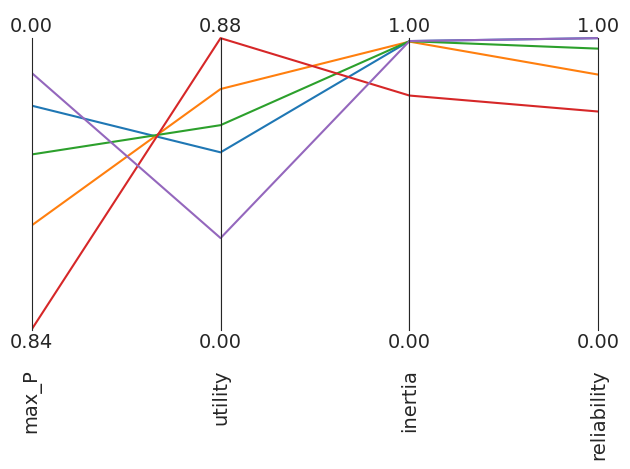

In [7]:
from ema_workbench.analysis import parcoords


data = resultsObjective

# get the minimum and maximum values as present in the dataframe
limits = parcoords.get_limits(data)

# we know that the lowest possible value for all objectives is 0
limits.loc[0, ["utility", "inertia", "reliability", "max_P"]] = 0
# inertia and reliability are defined on unit interval, so their theoretical maximum is 1
limits.loc[1, ["inertia", "reliability"]] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("max_P")

## 6. Establishing a performance threshold.
Show visually only the solutions from the Pareto set that yield a reliability above 80%, and briefly discuss the results.

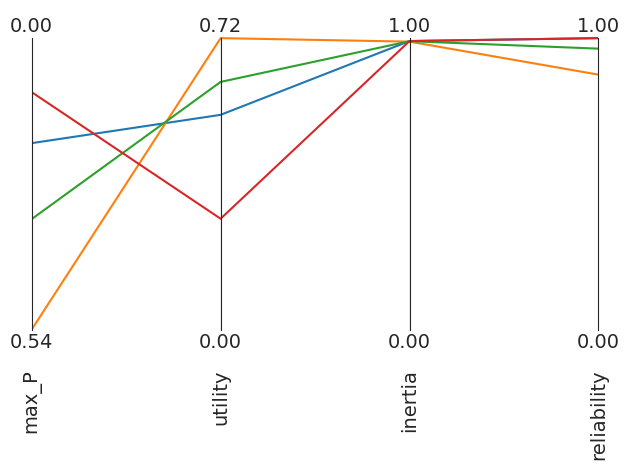

In [8]:

data = resultsObjective.query("reliability > 0.8")


# get the minimum and maximum values as present in the dataframe
limits = parcoords.get_limits(data)

# we know that the lowest possible value for all objectives is 0
limits.loc[0, ["utility", "inertia", "reliability", "max_P"]] = 0
# inertia and reliability are defined on unit interval, so their theoretical maximum is 1
limits.loc[1, ["inertia", "reliability"]] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("max_P")

# 7. Performance metrics
Show in a dataframe the results from the metrics (convergence) collected during the optimization. Plot the metrics (e.g hypervolume or epsilon progress) as a function of the number of function evaluations (nfe). Provide a brief discussion of the results.

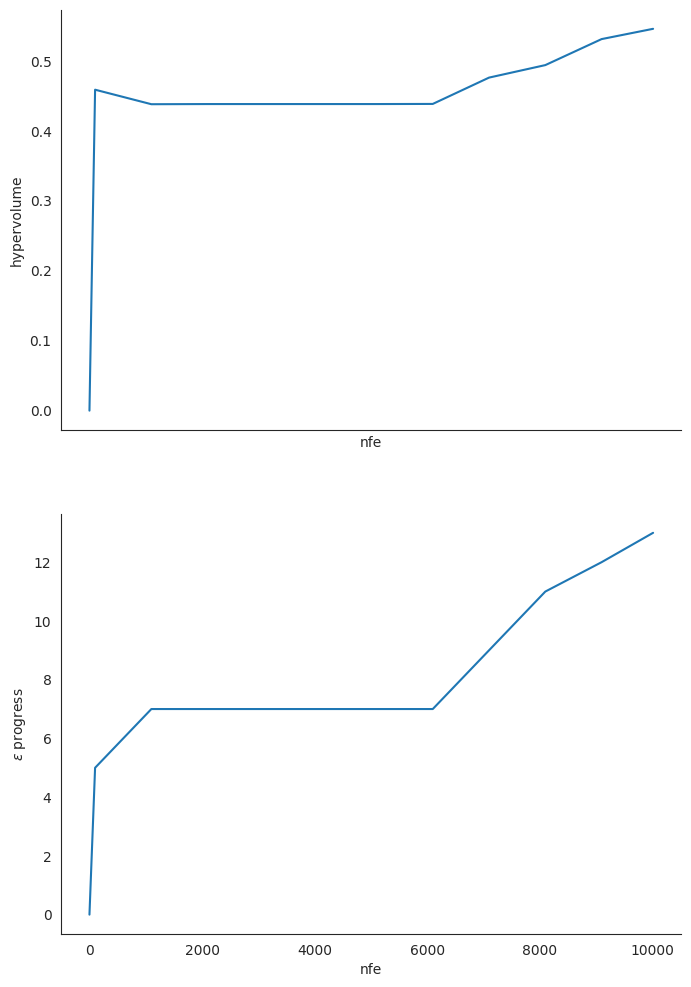

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

ax1.plot(convergence.nfe, convergence.hypervolume)
ax1.set_ylabel("hypervolume")
ax1.set_xlabel("nfe")

ax2.plot(convergence.nfe, convergence.epsilon_progress)
ax2.set_ylabel("$\epsilon$ progress")
ax2.set_xlabel("nfe")



sns.despine(fig)






### Extra credit: Visualize the phosphorous release from the policy with the highest reliability.   If you plot phosphorous release as a function of time, what do you observe?

Text(0, 0.5, 'p_release')

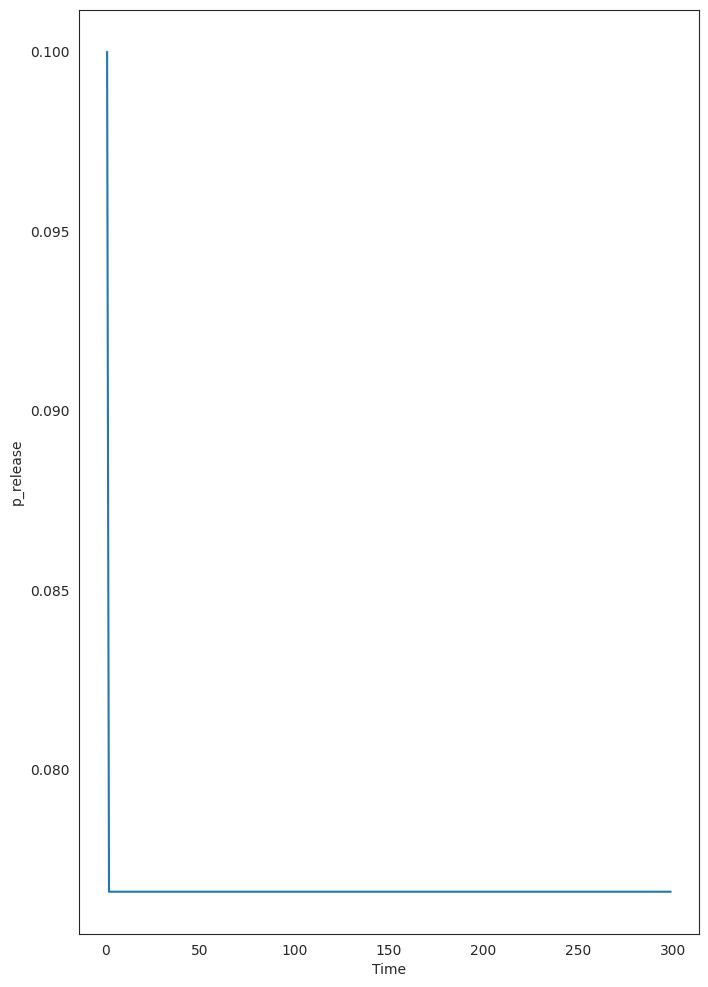

In [25]:
myears = 300

best_reliability = results.sort_values(by="reliability", ascending=False).iloc[0,:]
c1 = float(best_reliability[["c1","c2","r1","r2","w1"]].c1)
c2 = float(best_reliability[["c1","c2","r1","r2","w1"]].c2)
r1 = float(best_reliability[["c1","c2","r1","r2","w1"]].r1)
r2 = float(best_reliability[["c1","c2","r1","r2","w1"]].r2)
w1 = float(best_reliability[["c1","c2","r1","r2","w1"]].w1)


p_release = np.zeros(myears, )
p_release[0] = 0.1


X = np.zeros((myears,))

X[0] = 0.0
for t in range(1, myears):
    # here we use the decision rule
    p_releasei = get_antropogenic_release(X[t - 1], c1, c2, r1, r2, w1)
    p_release[t] = p_releasei

sns.set_style("white")
fig, axes = plt.subplots(nrows=1, figsize=(8, 12), sharex=True)

ax1 = axes

ax1.plot(range(1, myears), p_release[0:len(p_release)-1])
ax1.set_xlabel("Time")
ax1.set_ylabel("p_release")